# Setup

In [56]:
import sys
# sys.path.append("/kaggle/input/python-helpers/") # Comment this out when you are not in Kaggle kernel
sys.path.append("../") # Comment this out when you are in local environment
import utils
from utils import (
    # General Functions
    check_memory_usage, check_memory_by_global_variable, # For memory handling
    get_time_now, cprint, # For logging
    get_cols, downcast_to_32bit, my_concat, my_power, my_log, list_diff, # For preprocessing
    plot_feature_importance, plot_scatterplot, # For visualization
    get_feature_summary, # For feature engineering & feature selection
    check_auc, plot_heatmap, # For EDA
    # Competition Constants
    META_COLUMNS, 
    # Competition Functions
    filter_df, check_target_dependency, # EDA
    calculate_psi, # Validation
    clean_df, get_price_clippers, get_volume_clippers, clip_df, # Pre-processing: Clean & Clip
    calc_robust_scale, calc_std_scale, scale_base_columns,  # Pre-processing: Scaling
    setup_validation_zip, # Simulation
    lgbm_inference_by_batch, # Inference
    zero_sum, # Post-processing
)
from utils import (
    get_master_daily_target_data, generate_interday_target_features, get_master_daily_price_data, generate_interday_price_features, 
    get_master_daily_volume_data, generate_interday_volume_features
)

In [57]:
import gc
import joblib
import lightgbm as lgb
from lightgbm import LGBMRegressor, log_evaluation
import math
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False, nb_workers=12)
# import plotly.express as px
import random
import scipy.cluster.hierarchy as sch
import seaborn as sns
import time

from datetime import datetime
from itertools import combinations, groupby, product
from scipy.stats import pearsonr, chi2_contingency
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
tqdm.pandas()

import warnings
warnings.filterwarnings("ignore")
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [58]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
DATA_DIR = '../data/'

## Read Data

In [60]:
%%time
master_df = pd.read_parquet(f'{DATA_DIR}/optiver-train-data/clipped_train.parquet')
weight_df = pd.read_csv(f"{DATA_DIR}/optiver-support-data/stock_weight.csv")

CPU times: user 328 ms, sys: 423 ms, total: 751 ms
Wall time: 249 ms


In [61]:
base_columns = sorted(get_cols(master_df, contains=["price", "size"]))

In [62]:
# %%time
# revealed_targets = pd.read_csv(f'{DATA_DIR}/optiver-trading-at-the-close/example_test_files/revealed_targets.csv')
# test = pd.read_csv(f'{DATA_DIR}/optiver-trading-at-the-close/example_test_files/test.csv')
# sample_submission = pd.read_csv(f'{DATA_DIR}/optiver-trading-at-the-close/example_test_files/sample_submission.csv')

## Train Validation Split

In [63]:
TRAIN_END_DATE = 30
VAL_START_DATE = 421
VAL_END_DATE = 480

In [64]:
%%time
train = master_df.loc[master_df["date_id"] < TRAIN_END_DATE + 5].reset_index(drop=True)
# train = master_df.copy()

CPU times: user 16.6 ms, sys: 13.3 ms, total: 29.9 ms
Wall time: 28.7 ms


In [65]:
%%time
# val = master_df.loc[master_df["date_id"] >= VAL_START_DATE].reset_index(drop=True)
# val_iter_zip = setup_validation_zip(data_dir=DATA_DIR, val_start_date=TRAIN_END_DATE, val_end_date=TRAIN_END_DATE + 4)
# joblib.dump(val_iter_zip, f'{DATA_DIR}/optiver-train-data/iter_val_subset.pkl')

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 10 µs


# Stock Date Reference Features

In [66]:
del master_df
gc.collect()

225

In [67]:
%%time
train = train.sort_values(by=["stock_id", "date_id", "seconds"]).reset_index(drop=True)

CPU times: user 56.7 ms, sys: 13.2 ms, total: 69.9 ms
Wall time: 68 ms


In [68]:
train

,stock_id,date_id,seconds,imb_size,imb_flag,ref_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wa_price,target,clipped_target,is_positive_target,is_mild_target
0,0,0,0,3.180603e+06,1,0.999812,13380277.0,NaN,NaN,0.999812,60651.500000,1.000026,8493.030273,1.000000,-3.029704,-3.029704,0,1
1,0,0,10,1.299773e+06,1,1.000026,15261107.0,NaN,NaN,0.999812,13996.500000,1.000026,23519.160156,0.999892,0.389814,0.389814,1,1
2,0,0,20,1.299773e+06,1,0.999919,15261107.0,NaN,NaN,0.999812,4665.500000,0.999919,12131.599609,0.999842,4.220009,4.220009,1,1
3,0,0,30,1.299773e+06,1,1.000133,15261107.0,NaN,NaN,1.000026,55998.000000,1.000133,46203.300781,1.000085,5.450249,5.450249,1,0
4,0,0,40,1.218204e+06,1,1.000455,15342675.0,NaN,NaN,1.000241,14655.950195,1.000455,26610.449219,1.000317,3.169775,3.169775,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369375,198,34,500,-1.546665e+07,-1,1.003625,184153424.0,1.000783,1.000783,1.003625,19386.359375,1.003802,282423.875000,1.003636,-3.539920,-3.539920,0,1
369376,198,34,510,-1.546665e+07,-1,1.003625,184153424.0,1.000783,1.000783,1.003625,55333.078125,1.003802,476039.125000,1.003643,-3.150105,-3.150105,0,1
369377,198,34,520,-1.808905e+07,-1,1.003802,184122000.0,1.000783,1.000783,1.003802,124818.242188,1.003980,197833.453125,1.003871,-6.510019,-6.510019,0,0
369378,198,34,530,-1.808905e+07,-1,1.003802,184122000.0,1.000783,1.000783,1.003802,453257.531250,1.003980,53430.300781,1.003961,-5.090237,-5.090237,0,0


## Feature Preparation

In [69]:
# daily_price_df = pd.read_parquet("../daily_price.parquet")
# daily_target_df = pd.read_parquet("../daily_target.parquet")
# daily_volume_df = pd.read_parquet("../daily_volume.parquet")

In [70]:
%%time
daily_target_df = get_master_daily_target_data(train, verbose=1)
interday_target_features = generate_interday_target_features(daily_target_df, verbose=1)

3it [00:01,  2.11it/s]


Generating Interday gradient features for each column...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.10it/s]

CPU times: user 7.13 s, sys: 94.6 ms, total: 7.22 s
Wall time: 7.19 s


In [71]:
%%time
daily_price_df = get_master_daily_price_data(train, verbose=1)
interday_price_features = generate_interday_price_features(daily_price_df, verbose=1)

3it [00:01,  1.74it/s]


Generating Interday gradient features for each column...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:22<00:00,  2.14it/s]

CPU times: user 24.1 s, sys: 372 ms, total: 24.5 s
Wall time: 24.3 s


In [72]:
%%time
daily_volume_df = get_master_daily_volume_data(train, verbose=1)
interday_volume_features = generate_interday_volume_features(daily_volume_df, verbose=1)

3it [00:01,  1.73it/s]


Generating Interday gradient features for each column...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:21<00:00,  2.11it/s]

CPU times: user 22.9 s, sys: 380 ms, total: 23.3 s
Wall time: 23.1 s


In [73]:
# interday_target_features.to_parquet("../intraday_target.parquet")
# interday_price_features.to_parquet("../intraday_price.parquet")
# interday_volume_features.to_parquet("../intraday_volume.parquet")

In [74]:
# daily_target_df.to_parquet("../daily_target.parquet")
# daily_price_df.to_parquet("../daily_price.parquet")
# daily_volume_df.to_parquet("../daily_volume.parquet")

## Merge Additional Ready Data

In [75]:
def merge_additional_info(
    df, 
    merge_by_stock=[weight_df], 
    merge_by_stock_date=[interday_target_features, interday_price_features, interday_volume_features]
):
    # Merge static stock information
    for stock_df in merge_by_stock:
        df = df.merge(stock_df, on="stock_id", how="left")
    
    # Merge interday features
    for stock_date_df in merge_by_stock_date:
        df = df.merge(stock_date_df, left_on=["stock_id", "date_id"], right_index=True, how="left")
    return df

In [76]:
%%time
train = merge_additional_info(train)

CPU times: user 447 ms, sys: 927 ms, total: 1.37 s
Wall time: 1.61 s


In [77]:
check_memory_usage(color="blue")

RAM used: 3.8 GB


3.757659912109375

In [78]:
train.tail()

,stock_id,date_id,seconds,imb_size,imb_flag,ref_price,matched_size,far_price,near_price,bid_price,...,trade_size_r2_min_3days_gradient,trade_size_r2_min_6days_gradient,trade_size_r2_max_3days_gradient,trade_size_r2_max_6days_gradient,imb_size_ld1_r2_mean_3days_gradient,imb_size_ld1_r2_mean_6days_gradient,matched_size_ld1_r2_mean_3days_gradient,matched_size_ld1_r2_mean_6days_gradient,trade_size_ld1_r2_mean_3days_gradient,trade_size_ld1_r2_mean_6days_gradient
369375,198,34,500,-15466649.0,-1,1.003625,184153424.0,1.000783,1.000783,1.003625,...,-19525.953125,-30677.446652,97002.09375,-46570.419643,-678063.4375,-63629.358482,-548149.666667,414.67619,7589.632487,-2280.708045
369376,198,34,510,-15466649.0,-1,1.003625,184153424.0,1.000783,1.000783,1.003625,...,-19525.953125,-30677.446652,97002.09375,-46570.419643,-678063.4375,-63629.358482,-548149.666667,414.67619,7589.632487,-2280.708045
369377,198,34,520,-18089054.0,-1,1.003802,184122000.0,1.000783,1.000783,1.003802,...,-19525.953125,-30677.446652,97002.09375,-46570.419643,-678063.4375,-63629.358482,-548149.666667,414.67619,7589.632487,-2280.708045
369378,198,34,530,-18089054.0,-1,1.003802,184122000.0,1.000783,1.000783,1.003802,...,-19525.953125,-30677.446652,97002.09375,-46570.419643,-678063.4375,-63629.358482,-548149.666667,414.67619,7589.632487,-2280.708045
369379,198,34,540,-15313920.0,-1,1.003625,184306160.0,1.000783,1.000783,1.003447,...,-19525.953125,-30677.446652,97002.09375,-46570.419643,-678063.4375,-63629.358482,-548149.666667,414.67619,7589.632487,-2280.708045


# Interaction Features

## Interaction Features

In [79]:
base_price_cols = get_cols(train, contains="price", excludes=["median", "std", "rbtsc", "stdsc", "r0", "r1", "r2"])
base_volume_cols = get_cols(train, contains="size", excludes=["median", "std", "rbtsc", "stdsc", "r0", "r1", "r2"])

In [80]:
target_columns = ["target", "clipped_target", "binary_target"]
columns_to_shift = base_price_cols + base_volume_cols + get_cols(train, contains="flag")
columns_to_shift

['ref_price',
 'far_price',
 'near_price',
 'bid_price',
 'ask_price',
 'wa_price',
 'imb_size',
 'matched_size',
 'bid_size',
 'ask_size',
 'imb_flag']

In [81]:
def feature_engineering(df, around_one_price_cols=None, verbose=False):
    if verbose:
        cprint(f"{get_time_now()} Getting Price Interaction Features...", color="green")
    for p_col1, p_col2 in combinations(base_price_cols, 2):
        p1 = p_col1.replace("_price", "")
        p2 = p_col2.replace("_price", "")
        df[f"{p1}_{p2}_spread"] = df[p_col1] - df[p_col2]
        df[f"{p1}_{p2}_price"] = (df[p_col1] + df[p_col2]) / 2
        df[f"{p1}_{p2}_sp_ratio"] = df[f"{p1}_{p2}_spread"] / df[f"{p1}_{p2}_price"]
    
    df["bid_ask_price_ratio"] = df["bid_price"] / (df["ask_price"])
    
    if verbose:
        cprint(f"{get_time_now()} Getting Volume Interaction Features...", color="green")
    for v_col in base_volume_cols:
        # Apply log transformation on 4 volume columns
        df["log_" + v_col] = df[v_col].apply(np.log1p)
        
    df["abs_imb_size"] = df["imb_size"] * df["imb_flag"]
    df["bid_ask_size_sum"] = df["bid_size"] + df["ask_size"]
    df["bid_ask_size_diff"] = df["bid_size"] - df["ask_size"]
    df['bid_ask_size_ds_ratio'] = df["bid_ask_size_diff"] / df["bid_ask_size_sum"]
    df["match_imb_size"] = df["matched_size"] + df["abs_imb_size"]
    df["match_imb_size_diff"] = df["matched_size"] - df["abs_imb_size"]
    df['match_imb_size_ds_ratio'] = df["match_imb_size_diff"] / df["match_imb_size"]
    df["log_imb_matched_size_ratio"] = df["log_imb_size"] / df["log_matched_size"]
    df["sqrt_imb_matched_size_ratio"] = my_power(df["imb_size"] / df["matched_size"], 1/2)
    df["sqrt_abs_imb_matched_size_ratio"] = my_power(df["abs_imb_size"] / df["matched_size"], 1/2)
    df["log_bid_matched_size_ratio"] = df["log_bid_size"] / df["log_matched_size"]
    df["log_ask_matched_size_ratio"] = df["log_ask_size"] / df["log_matched_size"]
    df["log_bid_ask_diff_abs_imb_product"] = my_log(df["bid_ask_size_diff"] * df["abs_imb_size"])
    df["match_size_ratio"] = df["matched_size"] / (df["matched_size"] + df["imb_size"])
    df["bid_size_ratio"] = df["bid_size"] / (df["bid_size"] + df["ask_size"])
    df["ask_size_ratio"] = df["ask_size"] / (df["bid_size"] + df["ask_size"])
    df["bid_ask_size_ratio"] = df["bid_size"] / (df["ask_size"])
    
    if verbose:
        cprint(f"{get_time_now()} Getting Price-Volume Interaction Features...", color="green")
    df["ask_sp_product"] = df["ask_size"] * df["ask_price"]
    df["bid_sp_product"] = df["bid_size"] * df["bid_price"]
    df["bid_ask_sp_product_diff"] = df["ask_sp_product"] - df["bid_sp_product"]
    
    if verbose:
        cprint(f"{get_time_now()} Getting Zero-Centered-Price Interaction Features...", color="green")
    
    if around_one_price_cols is None:
        around_one_price_cols = df.columns[(df.min() > 0.6) & (df.max() < 1.4)].tolist()
        
    for p_col1, p_col2 in tqdm(combinations(around_one_price_cols, 2), disable=not verbose):
        p1 = p_col1.replace("_price", "")
        p2 = p_col2.replace("_price", "")
        if "_" not in p1 and "_" not in p2:
            temp1 = (df[p_col1] - 1)
            temp2 = (df[p_col2] - 1)
            df[f'{p1}_{p2}_sc_product'] = (temp1 * temp2).astype(np.float32)
            df[f'{p1}_{p2}_sc_ratio'] = (np.exp(temp1) / np.exp(temp2)).astype(np.float32)
    
    if verbose:
        cprint(f"{get_time_now()} Getting Price-Triplet Interaction Features...", color="green")
        
    for c in tqdm(combinations(around_one_price_cols, 3), disable=not verbose):
        p1 = c[0].replace("_price", "")
        p2 = c[1].replace("_price", "")
        p3 = c[2].replace("_price", "")
        if "_" not in p1 and "_" not in p2 and "_" not in p3:
            a = df[list(c)].fillna(1)
            max_ = a.max(axis=1)
            min_ = a.min(axis=1)
            mid_ = a.sum(axis=1) - min_ - max_
            df[f'{p1}_{p2}_{p3}_imb_ratio'] = (1 + max_ - mid_) / (1 + mid_ - min_)
    
    num_lags = 4
    if verbose:
        cprint(f"{get_time_now()} Getting Lag Features with max Lag={num_lags}...", color="green")
    # Group by 'stock_id' and 'date_id' and apply lags to selected columns
    for col in tqdm(columns_to_shift, disable=not verbose):
        for lag in range(1, num_lags + 1):
            df[f'{col}_l{lag}'] = df.groupby(['stock_id', 'date_id'])[col].shift(lag)
    
    for col in tqdm(columns_to_shift, disable=not verbose):
        if col.endswith("_price"):
            df[f"{col}_l1_ratio"] = df[col] / df[f"{col}_l1"]
            df[f"{col}_l2_ratio"] = df[col] / df[f"{col}_l2"]
            df[f"{col}_l1_l2_ratio_diff"] = df[f"{col}_l1_ratio"] - df[f"{col}_l2_ratio"]
            df[f"{col}_l0_l3_ma2_diff"] = (df[col] + df[f"{col}_l1"]) / (df[f"{col}_l2"] + df[f"{col}_l3"])
            
            l0 = (df[col] - 1)
            l1 = (df[f"{col}_l1"] - 1)
            l2 = (df[f"{col}_l2"] - 1)
            l3 = (df[f"{col}_l3"] - 1)
            df[f"{col}_sc_l1_ratio"] = np.exp(l0) / np.exp(l1)
            df[f"{col}_sc_l2_ratio"] = np.exp(l0) / np.exp(l2)
            df[f"{col}_sc_l1_l2_ratio_diff"] = df[f"{col}_sc_l1_ratio"] - df[f"{col}_sc_l2_ratio"]
            df[f"{col}_sc_l0_l3_ma_ratio"] = np.exp(l0 + l1) / np.exp(l2 + l3)
            
        elif col.endswith("_size") and not col.startswith("log_"):
            df[f"{col}_l1_ratio"] = df[col] / (df[col] + df[f"{col}_l1"])
            df[f"{col}_l2_ratio"] = df[col] / (df[col] + df[f"{col}_l2"])
            df[f"{col}_l1_l2_ratio_diff"] = (df[f"{col}_l1_ratio"] + df[f"{col}_l2_ratio"]) / 2
            df[f"{col}_l0_l3_ma2_diff"] = (
                np.log1p(df[col] + df[f"{col}_l1"]) / (1 + np.log1p(df[f"{col}_l2"] + df[f"{col}_l3"]))
            )
    return df, around_one_price_cols

In [82]:
%%time
train, around_one_price_cols = feature_engineering(train, verbose=True)

23:21:39 Getting Price Interaction Features...
23:21:39 Getting Volume Interaction Features...
23:21:39 Getting Price-Volume Interaction Features...
23:21:39 Getting Zero-Centered-Price Interaction Features...


2415it [00:00, 40631.23it/s]


23:21:40 Getting Price-Triplet Interaction Features...


54740it [00:01, 46337.29it/s]


23:21:41 Getting Lag Features with max Lag=4...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 117.17it/s]

CPU times: user 1.98 s, sys: 406 ms, total: 2.38 s
Wall time: 2.38 s


In [83]:
train = downcast_to_32bit(train)

Before downcast: 	RAM used: 4.3 GB


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 530/530 [00:00<00:00, 3778.42it/s]

After downcast: 	RAM used: 4.7 GB


In [84]:
def get_fod_sod(df, verbose=0):
    df = df.sort_values(by=["stock_id", "date_id", "seconds"]).reset_index(drop=True)
    temp_df = df.groupby(["stock_id", "date_id"])[base_columns].diff(1).add_suffix("_fod")
    
    for col in tqdm(temp_df.columns, disable=not verbose):
        if col not in df.columns:
            df[col] = temp_df[col]
    
    temp_df2 = df.groupby(["stock_id", "date_id"])[temp_df.columns].diff(1)
    temp_df2 = temp_df2.rename(columns={k: k.replace("_fod", "_sod") for k in temp_df2.columns})
    
    for col in tqdm(temp_df2.columns, disable=not verbose):
        if col not in df.columns:
            df[col] = temp_df2[col]
    
    temp_df3 = df.groupby(["stock_id", "date_id"])[temp_df.columns].cumsum()
    temp_df3 = temp_df3.rename(columns={k: k.replace("_fod", "_cumavg") for k in temp_df3.columns})
    
    for col in tqdm(temp_df3.columns, disable=not verbose):
        if col not in df.columns:
            df[col] = temp_df3[col] / (df["seconds"] / 10 + 1)
            
    for p_col1, p_col2 in tqdm(combinations(get_cols(df, endswith="price_fod"), 2), disable=not verbose):
        p1 = p_col1.replace("_price_fod", "")
        p2 = p_col2.replace("_price_fod", "")
        df[f"{p1}_{p2}_fod_spread"] = df[p_col1] - df[p_col2]
        df[f"{p1}_{p2}_fod_sum"] = df[p_col1] + df[p_col2]
        df[f"{p1}_{p2}_fod_ratio"] = df[f"{p1}_{p2}_fod_spread"] / df[f"{p1}_{p2}_fod_sum"]
        
    for v_col1, v_col2 in tqdm(combinations(get_cols(df, endswith="size_fod"), 2), disable=not verbose):
        v1 = v_col1.replace("_size_fod", "")
        v2 = v_col2.replace("_size_fod", "")
        df[f"{v1}_{v2}_fod_spread"] = df[v_col1] - df[v_col2]
        df[f"{v1}_{v2}_fod_sum"] = df[v_col1] + df[v_col2]
        df[f"{v1}_{v2}_fod_ratio"] = df[f"{v1}_{v2}_fod_spread"] / df[f"{v1}_{v2}_fod_sum"]
        
    return df

In [85]:
%%time
train = get_fod_sod(train, verbose=1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1349.74it/s]
15it [00:00, 991.34it/s]
6it [00:00, 876.03it/s]

CPU times: user 312 ms, sys: 659 ms, total: 971 ms
Wall time: 1.22 s


In [86]:
train = downcast_to_32bit(train)

Before downcast: 	RAM used: 3.4 GB


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1972.68it/s]

After downcast: 	RAM used: 3.3 GB


In [87]:
train.shape

(369380, 754)

In [88]:
%%time
train.to_parquet("../train_all.parquet")
# # train = pd.read_parquet("../train.parquet")

CPU times: user 5.03 s, sys: 168 ms, total: 5.2 s
Wall time: 4.96 s


In [37]:
# train = pd.read_parquet("../train_all.parquet")

In [38]:
# train_only = pd.read_parquet("../train_only.parquet")

## Test Submission Mode

In [43]:
%%time
val_iter_zip = joblib.load(f'{DATA_DIR}/optiver-train-data/iter_val_subset.pkl')
# val_iter_zip = joblib.load(f'{DATA_DIR}/optiver-test-data/iter_test_copy.pkl')

CPU times: user 153 ms, sys: 11.1 ms, total: 164 ms
Wall time: 164 ms


In [44]:
def process_revealed_targets(revealed_targets):
    revealed_targets = revealed_targets.drop(columns=["revealed_date_id", "revealed_time_id"], errors="ignore")
    revealed_targets["date_id"] -= 1
    revealed_targets = revealed_targets.rename(columns={"revealed_target": "target"})
    revealed_targets = clean_df(revealed_targets)
    daily_target_df = get_master_daily_target_data(revealed_targets)
    return daily_target_df

In [45]:
price_clippers = joblib.load(f"{DATA_DIR}/optiver-preprocess-helpers/price_clippers.pkl")
volume_clippers = joblib.load(f"{DATA_DIR}/optiver-preprocess-helpers/volume_clippers.pkl")

In [46]:
intraday_list = []
test_list = []
targets_list = []
sample_pred_list = []
count = 0
max_lookback_period = 14

In [49]:
recent_interday_price_features = filter_df(interday_price_features.reset_index(), date_id=TRAIN_END_DATE).set_index(["stock_id", "date_id"])
recent_interday_volume_features = filter_df(interday_volume_features.reset_index(), date_id=TRAIN_END_DATE).set_index(["stock_id", "date_id"])
recent_interday_target_features = filter_df(interday_target_features.reset_index(), date_id=TRAIN_END_DATE).set_index(["stock_id", "date_id"])

In [51]:
%%time
for i, (test, revealed_targets, sample_prediction) in tqdm(enumerate(val_iter_zip)):
    date_id = test["date_id"][0]
    test["order"] = range(test.shape[0])
    
    # Reset list if next day (seconds == 0) is seen
    second = test["seconds_in_bucket"].values[0]
    
    # If second == 0, means we get the full previous day info for building features
    if second == 0 and i > 0:
        # At this moment, the intraday df has the full 0 - 540 seconds data for the previous day
        
        # Get previous day price and volume df
        prev_day_price_df = get_master_daily_price_data(intraday_df)
        prev_day_volume_df = get_master_daily_volume_data(intraday_df)
        
        # Merge previous day prices (volumes) into master daily price (volume)
        daily_price_df = pd.concat([daily_price_df, prev_day_price_df]).sort_values(by=["stock_id", "date_id"]).reset_index()
        daily_price_df = daily_price_df.loc[daily_price_df["date_id"] > date_id - max_lookback_period].set_index(["stock_id", "date_id"])
        
        daily_volume_df = pd.concat([daily_volume_df, prev_day_volume_df]).sort_values(by=["stock_id", "date_id"]).reset_index()
        daily_volume_df = daily_volume_df.loc[daily_volume_df["date_id"] > date_id - max_lookback_period].set_index(["stock_id", "date_id"])
        
        # Generate interday price & volume features
        recent_interday_price_features = generate_interday_price_features(daily_price_df).reset_index()
        recent_interday_price_features = filter_df(recent_interday_price_features, date_id=date_id).set_index(["stock_id", "date_id"])
        
        recent_interday_volume_features = generate_interday_volume_features(daily_volume_df).reset_index()
        recent_interday_volume_features = filter_df(recent_interday_volume_features, date_id=date_id).set_index(["stock_id", "date_id"])
        
        # Reset intraday list
        intraday_list = []
        
        # Process previous revealed target
        prev_day_target_df = process_revealed_targets(revealed_targets)
        
        # Merge previous day targets into master daily target
        daily_target_df = pd.concat([daily_target_df, prev_day_target_df]).sort_values(by=["stock_id", "date_id"]).reset_index()
        daily_target_df = daily_target_df.loc[daily_target_df["date_id"] > date_id - max_lookback_period].set_index(["stock_id", "date_id"])
        
        # Generate interday target features
        recent_interday_target_features = generate_interday_target_features(daily_target_df).reset_index()
        recent_interday_target_features = filter_df(recent_interday_target_features, date_id=date_id).set_index(["stock_id", "date_id"])
        
        
    intraday_list.append(test)
    
    intraday_df = pd.concat(intraday_list, ignore_index=True)
    intraday_df = clean_df(intraday_df, verbose=0)
    intraday_df = clip_df(intraday_df, price_clippers=price_clippers, volume_clippers=volume_clippers)
    
    final_df = merge_additional_info(
        intraday_df, 
        merge_by_stock_date=[recent_interday_target_features, recent_interday_price_features, recent_interday_volume_features]
    )
    final_df, _ = feature_engineering(final_df, around_one_price_cols=around_one_price_cols)
    final_df = get_fod_sod(final_df)
    final_df = filter_df(final_df, seconds=second).sort_values(by="order").drop(columns="order").reset_index(drop=True)
    test_list.append(final_df)
    
    del final_df
    gc.collect()

275it [02:07,  2.16it/s]

CPU times: user 2min 2s, sys: 4.32 s, total: 2min 7s
Wall time: 2min 7s


In [52]:
%%time
full_test = my_concat(test_list)

CPU times: user 284 ms, sys: 48 ms, total: 332 ms
Wall time: 335 ms


In [55]:
# full_test.to_parquet("../test_only.parquet")

In [97]:
validate = filter_df(train, date_id=(full_test["date_id"].min(), full_test["date_id"].max()))

In [98]:
validate = validate.sort_values(by=["stock_id", "date_id", "seconds"]).reset_index(drop=True)
full_test = full_test.sort_values(by=["stock_id", "date_id", "seconds"]).reset_index(drop=True)

In [104]:
full_test

,stock_id,date_id,seconds,imb_size,imb_flag,ref_price,matched_size,far_price,near_price,bid_price,...,ask_matched_fod_ratio,bid_imb_fod_spread,bid_imb_fod_sum,bid_imb_fod_ratio,bid_matched_fod_spread,bid_matched_fod_sum,bid_matched_fod_ratio,imb_matched_fod_spread,imb_matched_fod_sum,imb_matched_fod_ratio
0,0,30,0,-8543019.0,-1,1.000799,6918829.5,NaN,NaN,0.999957,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,30,10,-9103628.0,-1,1.000062,7058317.0,NaN,NaN,0.999220,...,-0.896829,5.563360e+05,-5.648820e+05,-0.984871,-143760.453125,135214.546875,-1.063203,-700096.5,-421121.5,1.662457
2,0,30,20,-8906028.0,-1,0.999641,7255916.5,NaN,NaN,0.999536,...,-1.247230,-1.864954e+05,2.087046e+05,-0.893586,-186494.937500,208704.062500,-0.893586,0.5,395199.5,0.000001
3,0,30,30,-8906028.0,-1,0.998799,7255916.5,NaN,NaN,0.998799,...,1.000000,-8.164640e+03,-8.164640e+03,1.000000,-8164.640137,-8164.640137,1.000000,0.0,0.0,NaN
4,0,30,40,-8906028.0,-1,0.998904,7255916.5,NaN,NaN,0.998799,...,1.000000,-1.043240e+03,-1.043240e+03,1.000000,-1043.239990,-1043.239990,1.000000,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52795,198,34,500,-15466649.0,-1,1.003625,184153424.0,1.000783,1.000783,1.003625,...,0.855544,2.730150e+05,-2.777550e+05,-0.982935,7214.009766,-11953.990234,-0.603481,-265801.0,-284969.0,0.932737
52796,198,34,510,-15466649.0,-1,1.003625,184153424.0,1.000783,1.000783,1.003625,...,1.000000,3.594672e+04,3.594672e+04,1.000000,35946.718750,35946.718750,1.000000,0.0,0.0,NaN
52797,198,34,520,-18089054.0,-1,1.003802,184122000.0,1.000783,1.000783,1.003802,...,0.797022,2.691890e+06,-2.552920e+06,-1.054436,100909.164062,38061.164062,2.651237,-2590981.0,-2653829.0,0.976318
52798,198,34,530,-18089054.0,-1,1.003802,184122000.0,1.000783,1.000783,1.003802,...,1.000000,3.284393e+05,3.284393e+05,1.000000,328439.281250,328439.281250,1.000000,0.0,0.0,NaN


In [105]:
validate

,stock_id,date_id,seconds,imb_size,imb_flag,ref_price,matched_size,far_price,near_price,bid_price,...,ask_matched_fod_ratio,bid_imb_fod_spread,bid_imb_fod_sum,bid_imb_fod_ratio,bid_matched_fod_spread,bid_matched_fod_sum,bid_matched_fod_ratio,imb_matched_fod_spread,imb_matched_fod_sum,imb_matched_fod_ratio
0,0,30,0,-8543019.0,-1,1.000799,6918829.5,NaN,NaN,0.999957,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,30,10,-9103628.0,-1,1.000062,7058317.0,NaN,NaN,0.999220,...,-0.896829,5.563361e+05,-5.648819e+05,-0.984871,-143760.453125,135214.546875,-1.063203,-700096.5,-421121.5,1.662457
2,0,30,20,-8906028.0,-1,0.999641,7255916.5,NaN,NaN,0.999536,...,-1.247230,-1.864954e+05,2.087046e+05,-0.893586,-186494.937500,208704.062500,-0.893586,0.5,395199.5,0.000001
3,0,30,30,-8906028.0,-1,0.998799,7255916.5,NaN,NaN,0.998799,...,1.000000,-8.164640e+03,-8.164640e+03,1.000000,-8164.640137,-8164.640137,1.000000,0.0,0.0,NaN
4,0,30,40,-8906028.0,-1,0.998904,7255916.5,NaN,NaN,0.998799,...,1.000000,-1.043240e+03,-1.043240e+03,1.000000,-1043.239990,-1043.239990,1.000000,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52795,198,34,500,-15466649.0,-1,1.003625,184153424.0,1.000783,1.000783,1.003625,...,0.855544,2.730150e+05,-2.777550e+05,-0.982935,7214.009766,-11953.990234,-0.603481,-265801.0,-284969.0,0.932737
52796,198,34,510,-15466649.0,-1,1.003625,184153424.0,1.000783,1.000783,1.003625,...,1.000000,3.594672e+04,3.594672e+04,1.000000,35946.718750,35946.718750,1.000000,0.0,0.0,NaN
52797,198,34,520,-18089054.0,-1,1.003802,184122000.0,1.000783,1.000783,1.003802,...,0.797022,2.691890e+06,-2.552920e+06,-1.054436,100909.164062,38061.164062,2.651237,-2590981.0,-2653829.0,0.976318
52798,198,34,530,-18089054.0,-1,1.003802,184122000.0,1.000783,1.000783,1.003802,...,1.000000,3.284393e+05,3.284393e+05,1.000000,328439.281250,328439.281250,1.000000,0.0,0.0,NaN


In [111]:
(1 - ((validate[col] + 1e-6) / (full_test[col] + 1e-6))).max()

inf

In [124]:
col

'imb_matched_fod_ratio'

In [128]:
full_test.shape

(52800, 750)

In [127]:
full_test.loc[(f - v) > 0.1]

,stock_id,date_id,seconds,imb_size,imb_flag,ref_price,matched_size,far_price,near_price,bid_price,...,ask_matched_fod_ratio,bid_imb_fod_spread,bid_imb_fod_sum,bid_imb_fod_ratio,bid_matched_fod_spread,bid_matched_fod_sum,bid_matched_fod_ratio,imb_matched_fod_spread,imb_matched_fod_sum,imb_matched_fod_ratio
3026,11,30,10,1.028579e+05,1,0.999756,2.662660e+06,NaN,NaN,0.999220,...,-0.840583,2.705311e+05,-3.679639e+05,-0.735211,-3.679639e+05,2.705311e+05,-1.360154,-6.384950e+05,-0.007812,8.172736e+07
3161,11,32,260,2.167491e+05,1,1.000032,1.684401e+07,NaN,NaN,0.999950,...,-1.069216,8.799182e+05,-8.706539e+05,-1.010641,-8.706539e+05,8.799181e+05,-0.989471,-1.750572e+06,-0.031250,5.601830e+07
3286,11,34,410,2.166614e+05,1,1.001938,2.065324e+07,1.003420,1.002658,1.001431,...,-0.958433,3.887681e+05,-2.609799e+05,-1.489648,-2.609799e+05,3.887681e+05,-0.671300,-6.497480e+05,-0.015625,4.158387e+07
11059,40,31,40,5.382560e+03,1,1.000268,1.225791e+07,NaN,NaN,0.999897,...,-0.193090,3.682110e+04,-3.961118e+04,-0.929563,-3.961104e+04,3.682096e+04,-1.075774,-7.643214e+04,-0.139160,5.492387e+05
12943,47,30,180,3.183710e+03,1,1.001066,2.870611e+06,NaN,NaN,1.000516,...,-1.141596,2.698811e+05,-2.811729e+05,-0.959841,-2.811729e+05,2.698811e+05,-1.041840,-5.510540e+05,-0.008789,6.269770e+07
13531,49,31,10,2.219520e+03,1,0.999877,2.978967e+07,NaN,NaN,0.999629,...,-0.863124,5.405369e+05,-5.311296e+05,-1.017712,-5.311283e+05,5.405357e+05,-0.982596,-1.071665e+06,-1.229980,8.712864e+05
16711,60,33,460,3.558425e+04,1,1.005087,3.619211e+08,1.005126,1.005087,1.004820,...,-0.997202,7.344856e+06,-7.298586e+06,-1.006340,-7.298561e+06,7.344831e+06,-0.993700,-1.464342e+07,-24.750000,5.916532e+05
21311,78,32,260,1.441122e+04,1,1.002314,4.595754e+06,NaN,NaN,1.001359,...,-1.038866,7.659310e+04,-5.955940e+04,-1.285995,-5.955965e+04,7.659335e+04,-0.777609,-1.361527e+05,0.250977,-5.424919e+05
23372,86,34,520,1.110532e+06,1,0.998044,1.602998e+08,0.998861,0.998282,0.997806,...,-0.807021,-1.054450e+06,1.113102e+06,-0.947308,1.112814e+06,-1.054162e+06,-1.055639,2.167264e+06,288.095703,7.522723e+03
24523,91,30,480,7.484260e+04,1,1.002525,1.644532e+07,1.002675,1.002638,1.002413,...,-0.737358,9.010615e+05,-8.930226e+05,-1.009002,-8.930226e+05,9.010614e+05,-0.991078,-1.794084e+06,-0.023438,7.654758e+07


In [123]:
validate.loc[(f - v) > 0.1]

,stock_id,date_id,seconds,imb_size,imb_flag,ref_price,matched_size,far_price,near_price,bid_price,...,ask_matched_fod_ratio,bid_imb_fod_spread,bid_imb_fod_sum,bid_imb_fod_ratio,bid_matched_fod_spread,bid_matched_fod_sum,bid_matched_fod_ratio,imb_matched_fod_spread,imb_matched_fod_sum,imb_matched_fod_ratio
3026,11,30,10,1.028579e+05,1,0.999756,2.662660e+06,NaN,NaN,0.999220,...,-0.840583,2.705311e+05,-3.679639e+05,-0.735211,-3.679639e+05,2.705311e+05,-1.360154,-6.384950e+05,0.000000,-inf
3161,11,32,260,2.167491e+05,1,1.000032,1.684401e+07,NaN,NaN,0.999950,...,-1.069216,8.799181e+05,-8.706539e+05,-1.010641,-8.706539e+05,8.799181e+05,-0.989471,-1.750572e+06,0.000000,-inf
3286,11,34,410,2.166614e+05,1,1.001938,2.065324e+07,1.003420,1.002658,1.001431,...,-0.958433,3.887681e+05,-2.609799e+05,-1.489648,-2.609799e+05,3.887681e+05,-0.671300,-6.497480e+05,0.000000,-inf
11059,40,31,40,5.382560e+03,1,1.000268,1.225791e+07,NaN,NaN,0.999897,...,-0.193090,3.682110e+04,-3.961118e+04,-0.929563,-3.961104e+04,3.682096e+04,-1.075774,-7.643214e+04,-0.140625,5.435174e+05
12943,47,30,180,3.183710e+03,1,1.001066,2.870611e+06,NaN,NaN,1.000516,...,-1.141596,2.698811e+05,-2.811729e+05,-0.959841,-2.811729e+05,2.698811e+05,-1.041840,-5.510540e+05,0.000000,-inf
13531,49,31,10,2.219520e+03,1,0.999877,2.978967e+07,NaN,NaN,0.999629,...,-0.863124,5.405369e+05,-5.311296e+05,-1.017712,-5.311283e+05,5.405357e+05,-0.982596,-1.071665e+06,-1.250000,8.573322e+05
16711,60,33,460,3.558425e+04,1,1.005087,3.619211e+08,1.005126,1.005087,1.004820,...,-0.997202,7.344856e+06,-7.298586e+06,-1.006340,-7.298561e+06,7.344831e+06,-0.993700,-1.464342e+07,-25.000000,5.857367e+05
21311,78,32,260,1.441122e+04,1,1.002314,4.595754e+06,NaN,NaN,1.001359,...,-1.038866,7.659310e+04,-5.955940e+04,-1.285995,-5.955965e+04,7.659335e+04,-0.777609,-1.361528e+05,0.250000,-5.446110e+05
23372,86,34,520,1.110532e+06,1,0.998044,1.602998e+08,0.998861,0.998282,0.997806,...,-0.807021,-1.054450e+06,1.113102e+06,-0.947308,1.112814e+06,-1.054162e+06,-1.055639,2.167264e+06,288.125000,7.521958e+03
24523,91,30,480,7.484260e+04,1,1.002525,1.644532e+07,1.002675,1.002638,1.002413,...,-0.737358,9.010614e+05,-8.930226e+05,-1.009002,-8.930226e+05,9.010614e+05,-0.991078,-1.794084e+06,0.000000,-inf


In [117]:
v.describe()

count      35384.000000
mean      -16188.621094
std       216558.734375
min     -1000000.000000
25%           -1.000000
50%            0.000001
75%            1.000000
max      1000000.000000
Name: imb_matched_fod_ratio, dtype: float64

In [139]:
4.361572e-07 / 4.523112e-07

0.9642856511180797

In [154]:
full_test.shape[0], validate.shape[0]

(52800, 52800)

In [157]:
full_test.loc[(1 - v / f).abs() < 1e-3, col]

2        0.000774
3       -0.000470
4        0.000748
5        0.000132
6        0.000029
           ...   
52793    0.000193
52795   -0.000134
52796   -0.000179
52798   -0.000227
52799   -0.000090
Name: wa_price_l1_l2_ratio_diff, Length: 45251, dtype: float32

In [158]:
validate.loc[(1 - v / f).abs() < 1e-3, col]

2        0.000774
3       -0.000470
4        0.000748
5        0.000132
6        0.000029
           ...   
52793    0.000193
52795   -0.000134
52796   -0.000179
52798   -0.000227
52799   -0.000090
Name: wa_price_l1_l2_ratio_diff, Length: 45251, dtype: float32

In [159]:
full_test.loc[(1 - v / f).abs() > 1e-3, col]

10      -0.000032
40      -0.000053
66       0.000006
94      -0.000046
95      -0.000047
           ...   
52749    0.000084
52755    0.000038
52780   -0.000002
52794    0.000002
52797   -0.000007
Name: wa_price_l1_l2_ratio_diff, Length: 4860, dtype: float32

In [160]:
validate.loc[(1 - v / f).abs() > 1e-3, col]

10      -0.000032
40      -0.000053
66       0.000006
94      -0.000046
95      -0.000047
           ...   
52749    0.000084
52755    0.000038
52780   -0.000002
52794    0.000002
52797   -0.000007
Name: wa_price_l1_l2_ratio_diff, Length: 4860, dtype: float32

In [152]:
col = "wa_price_l1_l2_ratio_diff"

In [153]:
v = validate[col].clip(-1e6, 1e6)
f = full_test[col].clip(-1e6, 1e6)
deviate_many_count = ((1 - v / f).abs() > 1e-3).sum()

In [144]:
count = 0
for col in full_test.columns:
    v = validate[col].clip(-1e6, 1e6)
    f = full_test[col].clip(-1e6, 1e6)
    deviate_many_count = ((1 - v / f).abs() > 1e-3).sum()
    if deviate_many_count > 0:
        count += 1
        pct = deviate_many_count / full_test.shape[0]
        cprint(f"{col}: {pct:.3%}", color="blue")

ref_price_r0_mean_3days_gradient: 1.146%
ref_price_r0_mean_6days_gradient: 0.417%
bid_price_r0_mean_3days_gradient: 1.354%
bid_price_r0_mean_6days_gradient: 0.729%
wa_price_r0_mean_3days_gradient: 0.521%
wa_price_r0_mean_6days_gradient: 0.938%
ref_price_r1_mean_3days_gradient: 1.562%
ref_price_r1_mean_6days_gradient: 1.042%
bid_price_r1_mean_3days_gradient: 1.042%
bid_price_r1_mean_6days_gradient: 0.625%
wa_price_r1_mean_3days_gradient: 1.458%
wa_price_r1_mean_6days_gradient: 1.354%
bid_price_ld1_r1_mean_3days_gradient: 0.104%
ref_price_r2_mean_3days_gradient: 0.312%
ref_price_r2_mean_6days_gradient: 0.625%
bid_price_r2_mean_3days_gradient: 0.938%
bid_price_r2_mean_6days_gradient: 0.938%
bid_price_r2_std_3days_gradient: 0.104%
wa_price_r2_mean_3days_gradient: 0.521%
wa_price_r2_mean_6days_gradient: 0.833%
bid_price_ld1_r2_mean_3days_gradient: 0.208%
ask_price_ld1_r2_mean_3days_gradient: 0.312%
ref_price_l1_l2_ratio_diff: 2.231%
ref_price_sc_l1_l2_ratio_diff: 4.277%
far_price_l1_l2_rati

In [99]:
full_test

,stock_id,date_id,seconds,imb_size,imb_flag,ref_price,matched_size,far_price,near_price,bid_price,...,ask_matched_fod_ratio,bid_imb_fod_spread,bid_imb_fod_sum,bid_imb_fod_ratio,bid_matched_fod_spread,bid_matched_fod_sum,bid_matched_fod_ratio,imb_matched_fod_spread,imb_matched_fod_sum,imb_matched_fod_ratio
0,0,30,0,-8543019.0,-1,1.000799,6918829.5,NaN,NaN,0.999957,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,30,10,-9103628.0,-1,1.000062,7058317.0,NaN,NaN,0.999220,...,-0.896829,5.563360e+05,-5.648820e+05,-0.984871,-143760.453125,135214.546875,-1.063203,-700096.5,-421121.5,1.662457
2,0,30,20,-8906028.0,-1,0.999641,7255916.5,NaN,NaN,0.999536,...,-1.247230,-1.864954e+05,2.087046e+05,-0.893586,-186494.937500,208704.062500,-0.893586,0.5,395199.5,0.000001
3,0,30,30,-8906028.0,-1,0.998799,7255916.5,NaN,NaN,0.998799,...,1.000000,-8.164640e+03,-8.164640e+03,1.000000,-8164.640137,-8164.640137,1.000000,0.0,0.0,NaN
4,0,30,40,-8906028.0,-1,0.998904,7255916.5,NaN,NaN,0.998799,...,1.000000,-1.043240e+03,-1.043240e+03,1.000000,-1043.239990,-1043.239990,1.000000,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52795,198,34,500,-15466649.0,-1,1.003625,184153424.0,1.000783,1.000783,1.003625,...,0.855544,2.730150e+05,-2.777550e+05,-0.982935,7214.009766,-11953.990234,-0.603481,-265801.0,-284969.0,0.932737
52796,198,34,510,-15466649.0,-1,1.003625,184153424.0,1.000783,1.000783,1.003625,...,1.000000,3.594672e+04,3.594672e+04,1.000000,35946.718750,35946.718750,1.000000,0.0,0.0,NaN
52797,198,34,520,-18089054.0,-1,1.003802,184122000.0,1.000783,1.000783,1.003802,...,0.797022,2.691890e+06,-2.552920e+06,-1.054436,100909.164062,38061.164062,2.651237,-2590981.0,-2653829.0,0.976318
52798,198,34,530,-18089054.0,-1,1.003802,184122000.0,1.000783,1.000783,1.003802,...,1.000000,3.284393e+05,3.284393e+05,1.000000,328439.281250,328439.281250,1.000000,0.0,0.0,NaN


In [100]:
validate

,stock_id,date_id,seconds,imb_size,imb_flag,ref_price,matched_size,far_price,near_price,bid_price,...,ask_matched_fod_ratio,bid_imb_fod_spread,bid_imb_fod_sum,bid_imb_fod_ratio,bid_matched_fod_spread,bid_matched_fod_sum,bid_matched_fod_ratio,imb_matched_fod_spread,imb_matched_fod_sum,imb_matched_fod_ratio
0,0,30,0,-8543019.0,-1,1.000799,6918829.5,NaN,NaN,0.999957,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,30,10,-9103628.0,-1,1.000062,7058317.0,NaN,NaN,0.999220,...,-0.896829,5.563361e+05,-5.648819e+05,-0.984871,-143760.453125,135214.546875,-1.063203,-700096.5,-421121.5,1.662457
2,0,30,20,-8906028.0,-1,0.999641,7255916.5,NaN,NaN,0.999536,...,-1.247230,-1.864954e+05,2.087046e+05,-0.893586,-186494.937500,208704.062500,-0.893586,0.5,395199.5,0.000001
3,0,30,30,-8906028.0,-1,0.998799,7255916.5,NaN,NaN,0.998799,...,1.000000,-8.164640e+03,-8.164640e+03,1.000000,-8164.640137,-8164.640137,1.000000,0.0,0.0,NaN
4,0,30,40,-8906028.0,-1,0.998904,7255916.5,NaN,NaN,0.998799,...,1.000000,-1.043240e+03,-1.043240e+03,1.000000,-1043.239990,-1043.239990,1.000000,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52795,198,34,500,-15466649.0,-1,1.003625,184153424.0,1.000783,1.000783,1.003625,...,0.855544,2.730150e+05,-2.777550e+05,-0.982935,7214.009766,-11953.990234,-0.603481,-265801.0,-284969.0,0.932737
52796,198,34,510,-15466649.0,-1,1.003625,184153424.0,1.000783,1.000783,1.003625,...,1.000000,3.594672e+04,3.594672e+04,1.000000,35946.718750,35946.718750,1.000000,0.0,0.0,NaN
52797,198,34,520,-18089054.0,-1,1.003802,184122000.0,1.000783,1.000783,1.003802,...,0.797022,2.691890e+06,-2.552920e+06,-1.054436,100909.164062,38061.164062,2.651237,-2590981.0,-2653829.0,0.976318
52798,198,34,530,-18089054.0,-1,1.003802,184122000.0,1.000783,1.000783,1.003802,...,1.000000,3.284393e+05,3.284393e+05,1.000000,328439.281250,328439.281250,1.000000,0.0,0.0,NaN


In [39]:
# test_only = pd.read_parquet("../test_only.parquet")

In [43]:
validate = validate.reset_index(drop=True)

In [48]:
list_diff(validate.columns, test_only.columns)

['is_positive_target', 'clipped_target', 'is_mild_target', 'target']

In [69]:
validate

,stock_id,date_id,seconds,imb_size,imb_flag,ref_price,matched_size,far_price,near_price,bid_price,...,ask_matched_fod_ratio,bid_imb_fod_spread,bid_imb_fod_sum,bid_imb_fod_ratio,bid_matched_fod_spread,bid_matched_fod_sum,bid_matched_fod_ratio,imb_matched_fod_spread,imb_matched_fod_sum,imb_matched_fod_ratio
0,0,421,0,1.150879e+07,1,0.999406,11354174.0,NaN,NaN,0.999406,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,421,10,1.146589e+07,1,1.000167,11357118.0,NaN,NaN,0.999787,...,1.613970,77751.679688,-8044.320312,-9.665413,31909.679688,37797.679688,0.844223,-45842.0000,-39954.0000,1.147370
2,0,421,20,1.148581e+07,1,0.999787,11357118.0,NaN,NaN,0.999406,...,1.000000,-54095.660156,-14245.660156,3.797343,-34170.660156,-34170.660156,1.000000,19925.0000,19925.0000,1.000000
3,0,421,30,1.148581e+07,1,0.999787,11357118.0,NaN,NaN,0.999406,...,1.000000,2521.919922,2521.919922,1.000000,2521.919922,2521.919922,1.000000,0.0000,0.0000,NaN
4,0,421,40,1.104316e+07,1,0.999596,11799768.0,NaN,NaN,0.999406,...,-0.895805,422947.500000,-462352.500000,-0.914773,-462352.500000,422947.500000,-1.093168,-885300.0000,0.0000,-inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109995,199,430,500,-1.300706e+06,-1,1.003145,27733082.0,1.002812,1.002812,1.002812,...,1.000000,165147.500000,165147.500000,1.000000,165147.500000,165147.500000,1.000000,0.0000,0.0000,NaN
109996,199,430,510,-5.526023e+05,-1,1.002812,27788746.0,1.002812,1.002812,1.002812,...,-0.098872,-765899.500000,730308.375000,-1.048734,-73459.531250,37868.468750,-1.939860,692439.9375,803767.9375,0.861492
109997,199,430,520,-1.300706e+06,-1,1.003145,27733082.0,1.002812,1.002812,1.003145,...,-0.260985,785802.750000,-710405.125000,-1.106133,93362.812500,-17965.187500,-5.196874,-692439.9375,-803767.9375,0.861492
109998,199,430,530,-1.300706e+06,-1,1.003145,27733082.0,1.002812,1.002812,1.003145,...,1.000000,50457.468750,50457.468750,1.000000,50457.468750,50457.468750,1.000000,0.0000,0.0000,NaN


In [71]:
col = "target_r0_grad_ld1"

In [76]:
test_only

,stock_id,date_id,seconds,imb_size,imb_flag,ref_price,matched_size,far_price,near_price,bid_price,...,ref_near_wa_imb_ratio,far_near_bid_imb_ratio,far_near_ask_imb_ratio,far_near_wa_imb_ratio,far_bid_ask_imb_ratio,far_bid_wa_imb_ratio,far_ask_wa_imb_ratio,near_bid_ask_imb_ratio,near_bid_wa_imb_ratio,near_ask_wa_imb_ratio
0,0,421,0,1.150879e+07,1,0.999406,11354174.0,NaN,NaN,0.999406,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,421,10,1.146589e+07,1,1.000167,11357118.0,NaN,NaN,0.999787,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,421,20,1.148581e+07,1,0.999787,11357118.0,NaN,NaN,0.999406,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,421,30,1.148581e+07,1,0.999787,11357118.0,NaN,NaN,0.999406,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,421,40,1.104316e+07,1,0.999596,11799768.0,NaN,NaN,0.999406,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109995,199,430,500,-1.300706e+06,-1,1.003145,27733082.0,1.002812,1.002812,1.002812,...,0.999813,0.999999,1.000667,1.000260,1.000667,1.000260,1.000147,1.000667,1.000260,1.000147
109996,199,430,510,-5.526023e+05,-1,1.002812,27788746.0,1.002812,1.002812,1.002812,...,1.000109,0.999999,1.000333,1.000109,1.000333,1.000109,1.000114,1.000333,1.000109,1.000114
109997,199,430,520,-1.300706e+06,-1,1.003145,27733082.0,1.002812,1.002812,1.003145,...,0.999802,1.000333,1.000667,1.000468,1.000001,0.999802,0.999731,1.000001,0.999802,0.999731
109998,199,430,530,-1.300706e+06,-1,1.003145,27733082.0,1.002812,1.002812,1.003145,...,0.999780,1.000333,1.000667,1.000446,1.000001,0.999780,0.999776,1.000001,0.999780,0.999776


In [75]:
test_only.loc[(test_only[col] - validate[col]) > 1e-5, "date_id"].unique()

array([427, 429, 430, 425, 426, 428], dtype=int32)

target_r0_grad_ld1: 0.8701
target_r1_grad_ld1: 2.0447
target_r2_grad_ld1: 2.5159
target_r0_grad_ma2: 0.4753
target_r1_grad_ma2: 0.9711
target_r2_grad_ma2: 1.6292
daily_target_r0_mean_3days_gradient: 7.1564
daily_target_r0_mean_6days_gradient: 2.7346
daily_target_r0_std_3days_gradient: 11.5913
daily_target_r0_std_6days_gradient: 7.4214
daily_target_r0_min_3days_gradient: 21.3099
daily_target_r0_min_6days_gradient: 10.3321
daily_target_r0_max_3days_gradient: 30.5802
daily_target_r0_max_6days_gradient: 15.0298
daily_target_r1_mean_3days_gradient: 18.3382
daily_target_r1_mean_6days_gradient: 5.1928
daily_target_r1_std_3days_gradient: 18.1696
daily_target_r1_std_6days_gradient: 7.3785
daily_target_r1_min_3days_gradient: 21.3099
daily_target_r1_min_6days_gradient: 10.7328
daily_target_r1_max_3days_gradient: 34.8401
daily_target_r1_max_6days_gradient: 22.3052
daily_target_r2_mean_3days_gradient: 7.0470
daily_target_r2_mean_6days_gradient: 7.5399
daily_target_r2_std_3days_gradient: 10.9749
dai

In [52]:
validate

,stock_id,date_id,seconds,imb_size,imb_flag,ref_price,matched_size,far_price,near_price,bid_price,...,ask_matched_fod_ratio,bid_imb_fod_spread,bid_imb_fod_sum,bid_imb_fod_ratio,bid_matched_fod_spread,bid_matched_fod_sum,bid_matched_fod_ratio,imb_matched_fod_spread,imb_matched_fod_sum,imb_matched_fod_ratio
0,0,421,0,1.150879e+07,1,0.999406,11354174.0,NaN,NaN,0.999406,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,421,10,1.146589e+07,1,1.000167,11357118.0,NaN,NaN,0.999787,...,1.613970,77751.679688,-8044.320312,-9.665413,31909.679688,37797.679688,0.844223,-45842.0000,-39954.0000,1.147370
2,0,421,20,1.148581e+07,1,0.999787,11357118.0,NaN,NaN,0.999406,...,1.000000,-54095.660156,-14245.660156,3.797343,-34170.660156,-34170.660156,1.000000,19925.0000,19925.0000,1.000000
3,0,421,30,1.148581e+07,1,0.999787,11357118.0,NaN,NaN,0.999406,...,1.000000,2521.919922,2521.919922,1.000000,2521.919922,2521.919922,1.000000,0.0000,0.0000,NaN
4,0,421,40,1.104316e+07,1,0.999596,11799768.0,NaN,NaN,0.999406,...,-0.895805,422947.500000,-462352.500000,-0.914773,-462352.500000,422947.500000,-1.093168,-885300.0000,0.0000,-inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109995,199,430,500,-1.300706e+06,-1,1.003145,27733082.0,1.002812,1.002812,1.002812,...,1.000000,165147.500000,165147.500000,1.000000,165147.500000,165147.500000,1.000000,0.0000,0.0000,NaN
109996,199,430,510,-5.526023e+05,-1,1.002812,27788746.0,1.002812,1.002812,1.002812,...,-0.098872,-765899.500000,730308.375000,-1.048734,-73459.531250,37868.468750,-1.939860,692439.9375,803767.9375,0.861492
109997,199,430,520,-1.300706e+06,-1,1.003145,27733082.0,1.002812,1.002812,1.003145,...,-0.260985,785802.750000,-710405.125000,-1.106133,93362.812500,-17965.187500,-5.196874,-692439.9375,-803767.9375,0.861492
109998,199,430,530,-1.300706e+06,-1,1.003145,27733082.0,1.002812,1.002812,1.003145,...,1.000000,50457.468750,50457.468750,1.000000,50457.468750,50457.468750,1.000000,0.0000,0.0000,NaN


In [56]:
test_only = test_only.drop_duplicates(subset=META_COLUMNS).reset_index(drop=True)

0

In [ ]:

    
    
    
    
#         prev_day_target_stats = pd.concat(
#             [prev_day_target_stats, temp_target_stats]
#         ).drop_duplicates(subset=["stock_id", "date_id"], keep="first").reset_index(drop=True)
        
#     elif len(temp_list) == num_lags:
#         # If the list equals max_elem dataframes, remove the first dataframe then only append
#         temp_list.pop(0)
        
    
    count += 1
    # Concatenate the dataframes so that we can calculate lag features
    
    
    # Clean & Preprocess, then apply feature engineering
    
    a = scale_base_columns(
        a, 
        _level_stats_df=stock_level_stats, 
        level_col="stock", 
        join_col="stock_id", 
        base_columns=base_columns,
        verbose=0
    )
    a = scale_base_columns(
        a, 
        _level_stats_df=seconds_level_stats, 
        level_col="seconds", 
        join_col="seconds", 
        base_columns=base_columns,
        verbose=0
    )
    a = scale_base_columns(
        a, 
        _level_stats_df=stock_seconds_level_stats, 
        level_col="stock_seconds", 
        join_col=["stock_id", "seconds"], 
        base_columns=base_columns,
        verbose=0
    )
    a = scale_base_columns(
        a, 
        _level_stats_df=date_level_stats, 
        level_col="date", 
        join_col="date_id", 
        base_columns=base_columns,
        verbose=0
    )
    a = scale_base_columns(
        a, 
        _level_stats_df=stock_date_level_stats, 
        level_col="stock_date", 
        join_col=["stock_id", "date_id"], 
        base_columns=base_columns,
        verbose=0
    )
    a = merge_additional_info(a, pdts=temp_target_stats)
    a, _ = feature_engineering(a, around_one_price_cols=around_one_price_cols, verbose=False)
    a = get_fod_sod(a)

In [71]:
# check_chi_square_independece(train, col="normalized_stock_date_target_mean2_ma3_ma2_ratio", target_group_no=10, feature_group_no=10)

In [72]:
# for col in tqdm(train.columns[2:]):
#     train['feature_group'] = pd.qcut(train[col], q=8, duplicates="drop").cat.codes.replace(-1, np.nan)
#     table = pd.crosstab(train['feature_group'], train['target_group'])
#     chi2, p, dof, expected = chi2_contingency(table)
#     if p > 1e-2:
#         print(f"p-value {p:.4f}, column {col}")

In [73]:
# plt.figure(figsize=(25, 9))
# sns.heatmap(table[::-1], cmap="coolwarm", fmt=".0f", annot=True)
# plt.show()

In [74]:
# # Perform the chi-squared independence test
# chi2, p, dof, expected = chi2_contingency(table)
# p

In [75]:
# for col in train.columns[-17:]:
#     auc, proportion_drop = check_auc(train, col=col, target_col="is_mild_target", verbose=True)
#     print()

In [76]:
# def check_corr(df, col, target_col="clipped_target"):
#     temp = train[[col, "clipped_target"]].dropna()
#     dropped_proportion = 1 - temp.shape[0] / train.shape[0]
#     if dropped_proportion > 0.2:
#         cprint(f"{dropped_proportion:.3%} of the rows have been dropped due to NaN", color="red")
#     return temp.corr().values[1][0]

# Tree-Based Model Training

In [77]:
lgbm_best_params = {
    'boosting_type': 'gbdt', 
    'learning_rate': 0.02,
    'max_depth': 9,
    'n_estimators': 1300,
    'num_leaves': 400, # 416,
    'reg_alpha': 0.002,
    'reg_lambda': 0.0007,
    'colsample_bytree': 0.5,
    'subsample': 0.55,
    'min_child_samples': 128
}

In [78]:
default_settings = dict(
    # objective='cross_entropy', 
    objective='mae', 
    histogram_pool_size=512, 
    force_col_wise=True, 
    random_state=1020,
    max_bin=256, 
    n_jobs=-1, 
    verbose=-1
)

In [79]:
final_lgbm_params = default_settings | lgbm_best_params
print(final_lgbm_params)

{'objective': 'mae', 'histogram_pool_size': 512, 'force_col_wise': True, 'random_state': 1020, 'max_bin': 256, 'n_jobs': -1, 'verbose': -1, 'boosting_type': 'gbdt', 'learning_rate': 0.02, 'max_depth': 9, 'n_estimators': 1300, 'num_leaves': 400, 'reg_alpha': 0.002, 'reg_lambda': 0.0007, 'colsample_bytree': 0.5, 'subsample': 0.55, 'min_child_samples': 128}


In [80]:
VAL_DAYS = 60
MINIMUM_TRAIN_DAYS = 240
LAST_TRAIN_DATE = MINIMUM_TRAIN_DAYS + 3 * VAL_DAYS
LAST_TRAIN_DATE

420

In [81]:
%%time
# train = pd.read_parquet("../train_with_all_features.parquet")
# train = pl.read_parquet("../train_with_all_features.parquet")
# train = pd.read_parquet("../train_with_some_features.parquet")

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 1.91 µs


In [82]:
# train = train.drop(columns=get_cols(train, startswith="sc_", endswith=["size", "price", "flag"]))
# train = train.drop(columns=get_cols(train, startswith="sc_", endswith=("fod", "sod")))
# train = train.drop(columns=get_cols(train, contains="size", excludes=("log", "fod", "sod", "ratio", "diff")))
# train = train.drop(columns=get_cols(train, endswith=["l2", "l3", "l4"]))

In [83]:
FINAL_TARGET_COLUMN = "clipped_target"
cols_to_remove = ["date_id", "stock_id"]
add_list = []
# target_column_list = get_cols(train, "target", excludes=["ytd_", "normalized"])
# target_column_list

In [84]:
ab = pd.Series(train.columns)
target_column_list = ab[ab.str.contains("target") & ~ab.str.contains("|".join(["daily_", "normalized"]))].tolist()
target_column_list

['target', 'clipped_target', 'is_positive_target', 'is_mild_target']

In [85]:
train.shape

(5237980, 474)

In [86]:
train.head()

,stock_id,date_id,seconds,imb_size,imb_flag,ref_price,matched_size,far_price,near_price,bid_price,...,far_wa_fod_ratio,near_ref_fod_spread,near_ref_fod_sum,near_ref_fod_ratio,near_wa_fod_spread,near_wa_fod_sum,near_wa_fod_ratio,ref_wa_fod_spread,ref_wa_fod_sum,ref_wa_fod_ratio
0,0,0,0,3180602.750,1,0.999812,13380277.0,NaN,NaN,0.999812,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,10,1299772.750,1,1.000026,15261107.0,NaN,NaN,0.999812,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3761660.000,0.000,-inf
2,0,0,20,1299772.750,1,0.999919,15261107.0,NaN,NaN,0.999812,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.000,NaN
3,0,0,30,1299772.750,1,1.000133,15261107.0,NaN,NaN,1.000026,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.000,NaN
4,0,0,40,1218204.375,1,1.000455,15342675.0,NaN,NaN,1.000241,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-163136.375,-0.375,4.350303e+05


In [87]:
feature_list = list_diff(train.columns.tolist(), target_column_list + cols_to_remove + add_list)
len(feature_list)

468

In [88]:
def get_lgbm_dataset(df, start_date, end_date, feature_list, target="target", free_raw_data=True):
    temp = df.loc[df["date_id"].between(start_date, end_date)]
    data = lgb.Dataset(
        temp.loc[:, feature_list], 
        temp[target],
        free_raw_data=free_raw_data
    )
    return data

In [89]:
# %%time
# train = train.loc[:, train.columns[:550].tolist()]
# train.to_parquet("../train_with_some_features.parquet")

In [90]:
def objective(trial):
    va_score_list = []
    # sampled_features = random.sample(feature_list, 350)
    # track_features_list.append(sampled_features)
    for i in range(2, 4):
        cprint(f"{get_time_now()} Preparing Training Dataset...", color="green")
        train_data = get_lgbm_dataset(train, start_date=0, end_date=MINIMUM_TRAIN_DAYS + i * VAL_DAYS, feature_list=feature_list)
        # train_data = lgb.Dataset(
        #     tr.drop(columns=target_column_list + cols_to_remove + add_list, errors="ignore"), #.drop(columns=features_to_drop),
        #     tr["target"].values
        # )
        # del tr
        gc.collect()
        
        cprint(f"{get_time_now()} Preparing Validation Dataset...", color="green")
        valid_data = get_lgbm_dataset(train, start_date=MINIMUM_TRAIN_DAYS + i * VAL_DAYS + 1, end_date=MINIMUM_TRAIN_DAYS + (i + 1) * VAL_DAYS, feature_list=feature_list)
        
        # valid_data = lgb.Dataset(
        #     va.drop(columns=target_column_list + cols_to_remove + add_list, errors="ignore"), #.drop(columns=features_to_drop),
        #     va["target"].values,
        #     reference=train_data
        # )
        
        cprint(f"{get_time_now()} Suggesting hyparameters for this trial...", color="green")
        lgbm_trial_params = dict(
            boosting_type=trial.suggest_categorical("boosting_type", ["gbdt", "dart", "goss"]),
            learning_rate=trial.suggest_float("learning_rate", 0.02, 0.03), # 0.018052307589575444, 
            max_depth=trial.suggest_categorical("max_depth", [10, 11, 12, -1]), 
            n_estimators=trial.suggest_int("n_estimators", 400, 800, step=50),
            num_leaves=trial.suggest_int("num_leaves", 350, 450, step=25), 
            reg_alpha=trial.suggest_float("reg_alpha", 0.00001, 0.03, log=True), # 0.02216069565875271, 
            reg_lambda=trial.suggest_float("reg_lambda", 0.00001, 0.03, log=True), # 0.01223572246957101,
            colsample_bytree=trial.suggest_float("colsample_bytree", 0.5, 0.8),
            subsample=trial.suggest_float("subsample", 0.5, 0.95),
            min_child_samples=trial.suggest_int("min_child_samples", 32, 64, step=16),
            verbose=-1
        )
        final_lgbm_params = default_settings | lgbm_trial_params
        print(final_lgbm_params)
        
        cprint(f"{get_time_now()} Model Training...", color="green")
        model = lgb.train(
            params=final_lgbm_params,
            train_set=train_data, 
            valid_sets=[valid_data, train_data], 
            # feval=lgb_amex_metric, 
            # early_stopping_rounds=200,
            # categorical_feature=["stock_id"],
            callbacks=[
                log_evaluation(100),
            ]
        )
        del train_data, valid_data
        gc.collect()
        
        va = train.loc[train["date_id"].between(MINIMUM_TRAIN_DAYS + i * VAL_DAYS + 1, MINIMUM_TRAIN_DAYS + (i + 1) * VAL_DAYS)]
        va_pred = lgbm_inference_by_batch(model, va, verbose=0)
        va_score = (va_pred - va["target"]).abs().mean()
        
        va_pred_zero_sum = zero_sum(va_pred, va['bid_size'] + va['ask_size'])
        va_pred_zero_sum_score = (va_pred_zero_sum - va["target"]).abs().mean()
        
        cprint(f"{get_time_now()} Ori score: {va_score:.5f}, Zero sum score: {va_pred_zero_sum_score:.5f}", color="blue")
        va_score_list.append(va_pred_zero_sum_score)
        
    return np.mean(va_score_list)

In [99]:
# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=50)

In [ ]:
master_df.to_parquet(f"{DATA_DIR}/optiver-train-data/w18_features.parquet")

In [23]:
# new_train = pd.read_parquet("../data/optiver-train-data/train_with_all_features.parquet", columns=["stock_id", "date_id", "seconds"] + list_diff(potential_good_features, train.columns))

In [91]:
feature_list = list_diff(train.columns.tolist(), target_column_list + cols_to_remove + add_list)
len(feature_list)

468

In [92]:
# del new_train

In [93]:
train = downcast_to_32bit(train)
check_memory_usage(color="blue")

Before downcast: 	RAM used: 2.9 GB


0it [00:00, ?it/s]

After downcast: 	RAM used: 2.9 GB
RAM used: 2.9 GB


2.913299560546875

In [103]:
# val = filter_df(train, date_id=(421, 480))
# train = filter_df(train, date_id=(0, 420))

In [104]:
# psi_list = []
# for feature in get_cols(val, contains=["price", "val"]):
#     psi_ = calculate_psi(train[feature].clip(1e6, -1e6).dropna(), val[feature].clip(1e6, -1e6).dropna())
#     if psi_ > 0.2:
#         cprint(f"PSI for {feature}: {psi_:.4f}", color="red")
#     elif psi_ > 0.1:
#         cprint(f"PSI for {feature}: {psi_:.4f}", color="yellow")
#     else:
#         cprint(f"PSI for {feature}: {psi_:.4f}", color="blue")
#     psi_list.append(psi_)

In [105]:
# psi_list2 = []
# for feature in feature_list:
#     psi_ = calculate_psi2(train[feature].clip(1e6, -1e6).dropna(), val[feature].clip(1e6, -1e6).dropna())
#     if psi_ > 0.2:
#         cprint(f"PSI for {feature}: {psi_:.4f}", color="red")
#     elif psi_ > 0.1:
#         cprint(f"PSI for {feature}: {psi_:.4f}", color="yellow")
#     else:
#         cprint(f"PSI for {feature}: {psi_:.4f}", color="blue")
#     psi_list2.append(psi_)

In [106]:
# feature_psi_df = pd.DataFrame(dict(feature=get_cols(val, contains=["price", "val"]), psi=psi_list))
# feature_psi_df.to_csv("../new_psi_df.csv", index=False)

In [107]:
# %%time
# train = pd.concat([train, val], ignore_index=True)
# del val
# gc.collect()
# check_memory_usage(color="blue")

In [94]:
%%time
va_score_list = []
model_list = []
va_pred_list = []
va_list = []
track_features_list = []
for i in range(1):
    # np.random.seed(i)
    # sampled_features = random.sample(feature_list, 350)
    # track_features_list.append(sampled_features)
    
    cprint(f"{get_time_now()} Preparing Dataset...", color="green")
    train_data = get_lgbm_dataset(train, start_date=0, end_date=LAST_TRAIN_DATE, feature_list=feature_list) 
    valid_data = get_lgbm_dataset(train, start_date=LAST_TRAIN_DATE + 1, end_date=480, feature_list=feature_list, free_raw_data=False)
    
    gc.collect()
    cprint(f"{get_time_now()} Training...", color="green")
    model = lgb.train(
        params=final_lgbm_params,
        train_set=train_data, 
        valid_sets=[valid_data, train_data], 
        # feval=lgb_amex_metric, 
        # early_stopping_rounds=200,
        # categorical_feature=["stock_id"],
        callbacks=[
            log_evaluation(100),
        ]
    )
    del train_data
    gc.collect()
    
    # model_list.append(model)
    model.save_model(f'../models/lgbm/lgbm_model5_val.txt')
#     va_pred = lgbm_inference_by_batch(model, va)
#     va_pred_list.append(va_pred)

#     va_score = (va_pred - va["target"]).abs().mean()
#     cprint(f"{get_time_now()} {va_score:.5f}", color="blue")
#     va_score_list.append(va_score)

01:41:34 Preparing Dataset...
01:42:14 Training...
[100]	training's l1: 6.32306	valid_0's l1: 5.71086
[200]	training's l1: 6.27331	valid_0's l1: 5.69567
[300]	training's l1: 6.23982	valid_0's l1: 5.68929
[400]	training's l1: 6.21452	valid_0's l1: 5.68625
[500]	training's l1: 6.19161	valid_0's l1: 5.68431
[600]	training's l1: 6.16823	valid_0's l1: 5.68311
[700]	training's l1: 6.14751	valid_0's l1: 5.68258
[800]	training's l1: 6.12868	valid_0's l1: 5.68209
[900]	training's l1: 6.10935	valid_0's l1: 5.68106
[1000]	training's l1: 6.09096	valid_0's l1: 5.68064
[1100]	training's l1: 6.07354	valid_0's l1: 5.68068
[1200]	training's l1: 6.05634	valid_0's l1: 5.68055
[1300]	training's l1: 6.03983	valid_0's l1: 5.6804
CPU times: user 3h 1min 49s, sys: 9min 30s, total: 3h 11min 20s
Wall time: 23min 51s


01:05:01 Preparing Dataset...
01:05:49 Training...
[100]	training's l1: 6.322	valid_0's l1: 5.71214
[200]	training's l1: 6.27182	valid_0's l1: 5.69639
[300]	training's l1: 6.2353	valid_0's l1: 5.69002
[400]	training's l1: 6.20531	valid_0's l1: 5.687
[500]	training's l1: 6.17829	valid_0's l1: 5.68556
[600]	training's l1: 6.15309	valid_0's l1: 5.68443
[700]	training's l1: 6.12831	valid_0's l1: 5.68353
[800]	training's l1: 6.10595	valid_0's l1: 5.68296
[900]	training's l1: 6.08456	valid_0's l1: 5.68253
[1000]	training's l1: 6.0623	valid_0's l1: 5.6823
[1100]	training's l1: 6.04075	valid_0's l1: 5.68191
[1200]	training's l1: 6.02163	valid_0's l1: 5.68197
[1300]	training's l1: 6.00253	valid_0's l1: 5.68237
CPU times: user 3h 37min 18s, sys: 11min 11s, total: 3h 48min 30s
Wall time: 28min 12s


In [64]:
%%time
va_score_list = []
model_list = []
va_pred_list = []
va_list = []
track_features_list = []
for i in range(1):
    # np.random.seed(i)
    # sampled_features = random.sample(feature_list, 350)
    # track_features_list.append(sampled_features)
    
    cprint(f"{get_time_now()} Preparing Dataset...", color="green")
    train_data = get_lgbm_dataset(train, start_date=0, end_date=LAST_TRAIN_DATE, feature_list=feature_list) 
    valid_data = get_lgbm_dataset(train, start_date=LAST_TRAIN_DATE + 1, end_date=480, feature_list=feature_list, free_raw_data=False)
    
    gc.collect()
    cprint(f"{get_time_now()} Training...", color="green")
    model = lgb.train(
        params=final_lgbm_params,
        train_set=train_data, 
        valid_sets=[valid_data, train_data], 
        # feval=lgb_amex_metric, 
        # early_stopping_rounds=200,
        # categorical_feature=["stock_id"],
        callbacks=[
            log_evaluation(100),
        ]
    )
    del train_data
    gc.collect()
    
    # model_list.append(model)
    model.save_model(f'../models/lgbm/lgbm_model5_val.txt')
#     va_pred = lgbm_inference_by_batch(model, va)
#     va_pred_list.append(va_pred)

#     va_score = (va_pred - va["target"]).abs().mean()
#     cprint(f"{get_time_now()} {va_score:.5f}", color="blue")
#     va_score_list.append(va_score)

06:36:18 Preparing Dataset...
06:36:52 Training...
[100]	training's l1: 6.32345	valid_0's l1: 5.71087
[200]	training's l1: 6.27765	valid_0's l1: 5.69522
[300]	training's l1: 6.24863	valid_0's l1: 5.68875
[400]	training's l1: 6.22741	valid_0's l1: 5.68541
[500]	training's l1: 6.20724	valid_0's l1: 5.68322
[600]	training's l1: 6.18952	valid_0's l1: 5.68185
[700]	training's l1: 6.17353	valid_0's l1: 5.681
[800]	training's l1: 6.15843	valid_0's l1: 5.68032
[900]	training's l1: 6.14514	valid_0's l1: 5.67987
[1000]	training's l1: 6.13234	valid_0's l1: 5.67947
[1100]	training's l1: 6.1198	valid_0's l1: 5.67914
[1200]	training's l1: 6.10817	valid_0's l1: 5.67905
[1300]	training's l1: 6.09692	valid_0's l1: 5.67904
CPU times: user 2h 34min 12s, sys: 8min 30s, total: 2h 42min 43s
Wall time: 20min 22s


05:02:18 Preparing Dataset...
05:03:02 Training...
[100]	training's l1: 6.31957	valid_0's l1: 5.70981
[200]	training's l1: 6.26869	valid_0's l1: 5.69277
[300]	training's l1: 6.23721	valid_0's l1: 5.68607
[400]	training's l1: 6.21397	valid_0's l1: 5.68235
[500]	training's l1: 6.19345	valid_0's l1: 5.68014
[600]	training's l1: 6.17301	valid_0's l1: 5.67832
[700]	training's l1: 6.15654	valid_0's l1: 5.67735
[800]	training's l1: 6.14008	valid_0's l1: 5.67648
[900]	training's l1: 6.12393	valid_0's l1: 5.67582
[1000]	training's l1: 6.10993	valid_0's l1: 5.67545
[1100]	training's l1: 6.09713	valid_0's l1: 5.6753
[1200]	training's l1: 6.08449	valid_0's l1: 5.67513
[1300]	training's l1: 6.0716	valid_0's l1: 5.67477
CPU times: user 2h 38min 31s, sys: 8min 13s, total: 2h 46min 44s
Wall time: 20min 48s


In [65]:
del model, valid_data
gc.collect()
check_memory_usage(color="blue")

RAM used: 2.1 GB


2.13665771484375

In [66]:
%%time
va_score_list = []
model_list = []
va_pred_list = []
va_list = []
track_features_list = []
for i in range(1):
    # np.random.seed(i)
    # sampled_features = random.sample(feature_list, 350)
    # track_features_list.append(sampled_features)
    
    cprint(f"{get_time_now()} Preparing Dataset...", color="green")
    train_data = get_lgbm_dataset(train, start_date=0, end_date=480, feature_list=feature_list) 
    valid_data2 = get_lgbm_dataset(train, start_date=LAST_TRAIN_DATE + 1, end_date=480, feature_list=feature_list, free_raw_data=False)
    
    gc.collect()
    cprint(f"{get_time_now()} Training...", color="green")
    model2 = lgb.train(
        params=final_lgbm_params,
        train_set=train_data, 
        valid_sets=[valid_data2, train_data], 
        # feval=lgb_amex_metric, 
        # early_stopping_rounds=200,
        # categorical_feature=["stock_id"],
        callbacks=[
            log_evaluation(100),
        ]
    )
    del train_data
    gc.collect()
    
    # model_list.append(model)
    model2.save_model(f'../models/lgbm/lgbm_model5.txt')
#     va_pred = lgbm_inference_by_batch(model, va)
#     va_pred_list.append(va_pred)

#     va_score = (va_pred - va["target"]).abs().mean()
#     cprint(f"{get_time_now()} {va_score:.5f}", color="blue")
#     va_score_list.append(va_score)

06:56:41 Preparing Dataset...
06:57:25 Training...
[100]	training's l1: 6.24647	valid_0's l1: 5.68872
[200]	training's l1: 6.20406	valid_0's l1: 5.65156
[300]	training's l1: 6.17774	valid_0's l1: 5.62807
[400]	training's l1: 6.15683	valid_0's l1: 5.60854
[500]	training's l1: 6.13987	valid_0's l1: 5.59275
[600]	training's l1: 6.12396	valid_0's l1: 5.5778
[700]	training's l1: 6.10948	valid_0's l1: 5.56406
[800]	training's l1: 6.097	valid_0's l1: 5.55228
[900]	training's l1: 6.08447	valid_0's l1: 5.54061
[1000]	training's l1: 6.07194	valid_0's l1: 5.52888
[1100]	training's l1: 6.05975	valid_0's l1: 5.51761
[1200]	training's l1: 6.04838	valid_0's l1: 5.50678
[1300]	training's l1: 6.03918	valid_0's l1: 5.49847
CPU times: user 2h 55min 5s, sys: 8min 41s, total: 3h 3min 46s
Wall time: 23min 46s


In [67]:
val = valid_data2.get_data()

In [40]:
train[["stock_id", "date_id", "seconds", "imb_size", "imb_size_cumavg"]]

,stock_id,date_id,seconds,imb_size,imb_size_cumavg
0,0,0,0,3180602.750,NaN
1,0,0,10,1299772.750,-940415.000000
2,0,0,20,1299772.750,-626943.312500
3,0,0,30,1299772.750,-470207.500000
4,0,0,40,1218204.375,-392479.687500
...,...,...,...,...,...
5237975,199,480,500,-2661783.500,111221.960938
5237976,199,480,510,-2658917.500,109138.195312
5237977,199,480,520,-1352558.875,131727.250000
5237978,199,480,530,-1352558.875,129287.859375


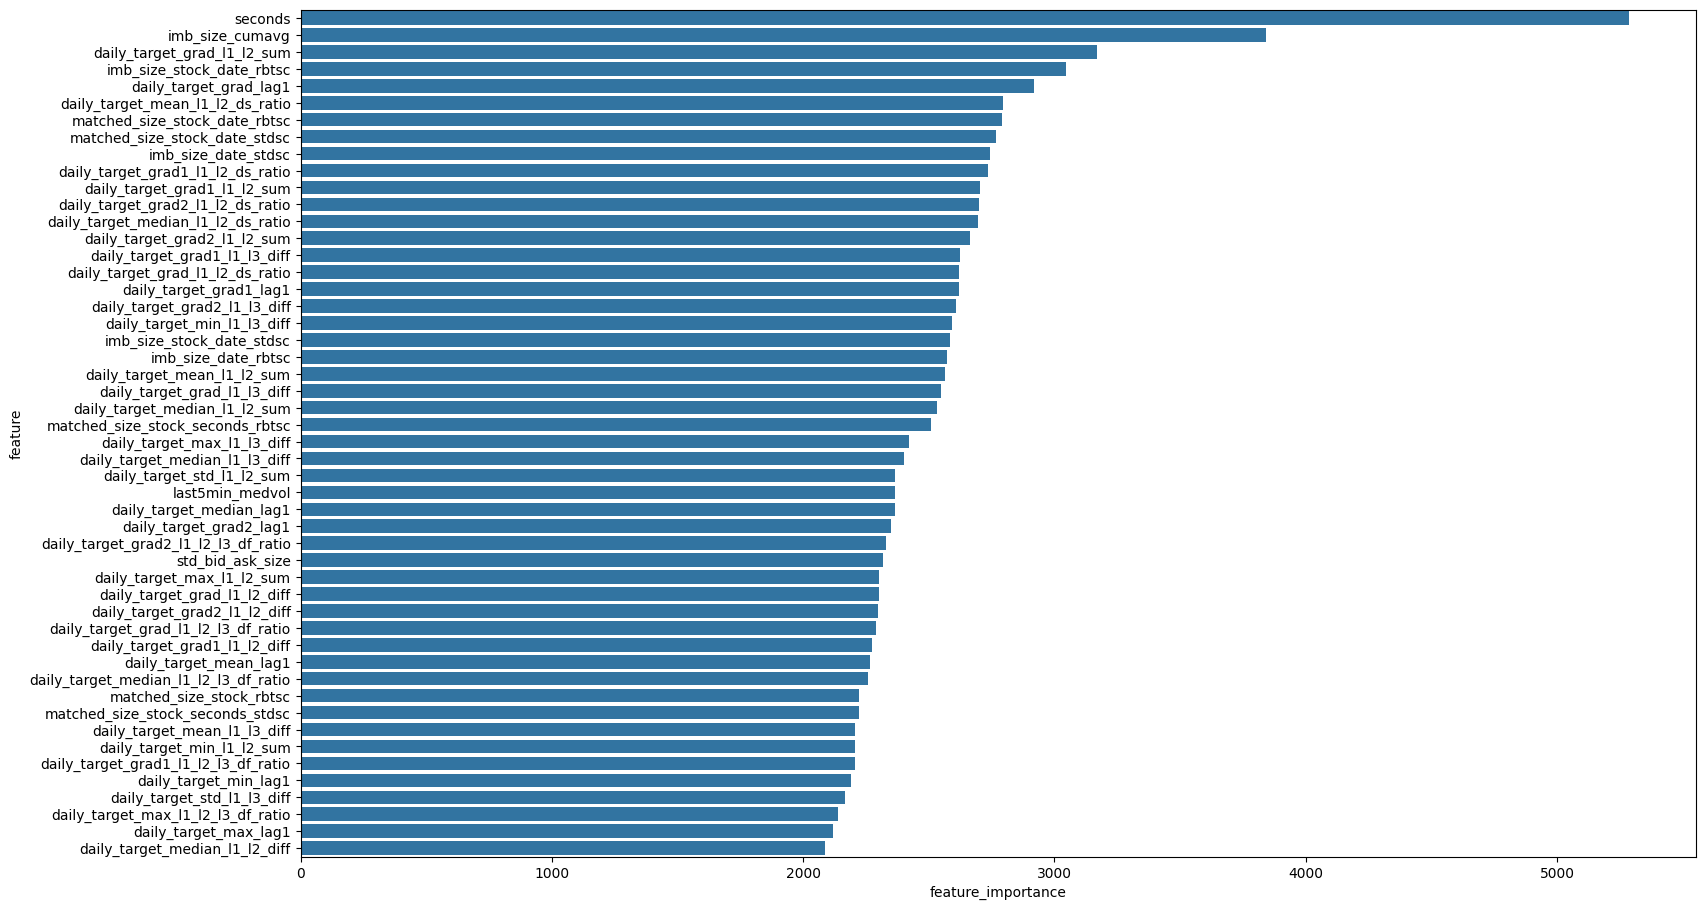

In [95]:
lgbm_model = lgb.Booster(model_file=f"../models/lgbm/lgbm_model5_val.txt")
previous_feature_list = lgbm_model.feature_name()
feature_imp_df = plot_feature_importance(
    features=lgbm_model.feature_name(), importances=lgbm_model.feature_importance(), return_df=True, limit=50, figsize=(18, 11)
)

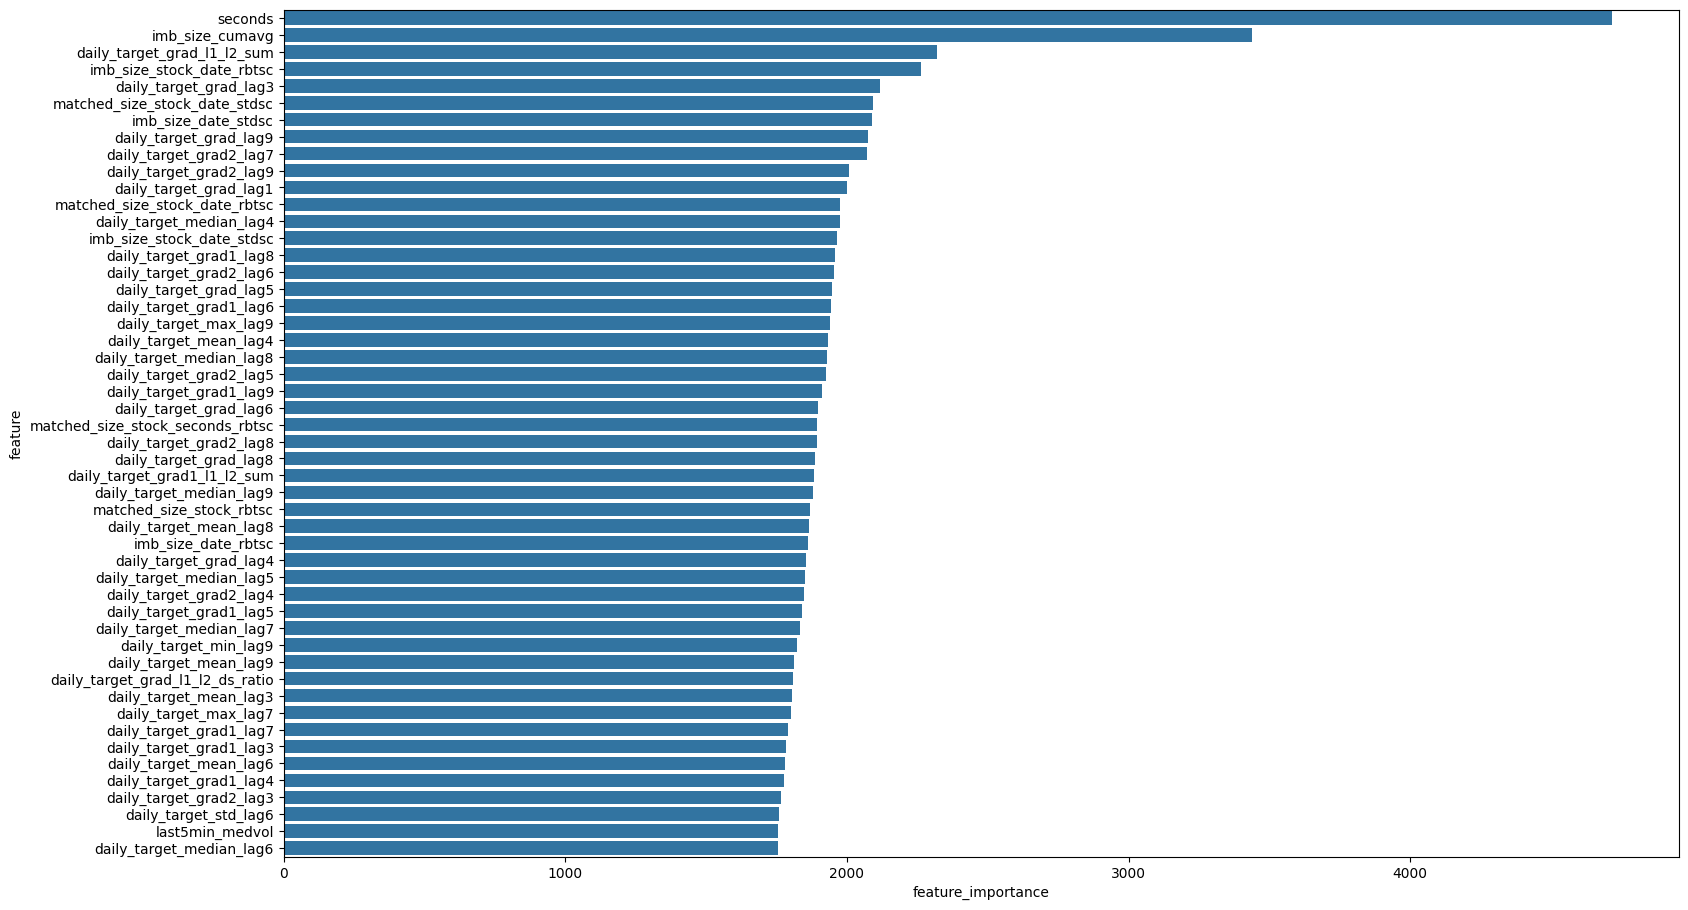

In [109]:
lgbm_model = lgb.Booster(model_file=f"../models/lgbm/lgbm_model5_val.txt")
previous_feature_list = lgbm_model.feature_name()
feature_imp_df = plot_feature_importance(
    features=lgbm_model.feature_name(), importances=lgbm_model.feature_importance(), return_df=True, limit=50, figsize=(18, 11)
)

In [68]:
%%time
va_score_list = []
model_list = []
va_pred_list = []
va_list = []
track_features_list = []
for i in range(1):
    # np.random.seed(i)
    # sampled_features = random.sample(feature_list, 350)
    # track_features_list.append(sampled_features)
    
    cprint(f"{get_time_now()} Preparing Dataset...", color="green")
    train_data = get_lgbm_dataset(train, start_date=0, end_date=480, feature_list=feature_list) 
    valid_data2 = get_lgbm_dataset(train, start_date=LAST_TRAIN_DATE + 1, end_date=480, feature_list=feature_list, free_raw_data=False)
    
    gc.collect()
    cprint(f"{get_time_now()} Training...", color="green")
    model2 = lgb.train(
        params=final_lgbm_params,
        train_set=train_data, 
        valid_sets=[valid_data2, train_data], 
        # feval=lgb_amex_metric, 
        # early_stopping_rounds=200,
        # categorical_feature=["stock_id"],
        callbacks=[
            log_evaluation(100),
        ]
    )
    del train_data
    gc.collect()
    
    # model_list.append(model)
    model2.save_model(f'../models/lgbm/lgbm_model5.txt')
#     va_pred = lgbm_inference_by_batch(model, va)
#     va_pred_list.append(va_pred)

#     va_score = (va_pred - va["target"]).abs().mean()
#     cprint(f"{get_time_now()} {va_score:.5f}", color="blue")
#     va_score_list.append(va_score)

00:55:54 Preparing Dataset...
00:56:40 Training...
[100]	training's l1: 6.24388	valid_0's l1: 5.69764
[200]	training's l1: 6.1973	valid_0's l1: 5.66798
[300]	training's l1: 6.1675	valid_0's l1: 5.6506
[400]	training's l1: 6.14535	valid_0's l1: 5.63712
[500]	training's l1: 6.1265	valid_0's l1: 5.62635
[600]	training's l1: 6.10942	valid_0's l1: 5.61723
[700]	training's l1: 6.09367	valid_0's l1: 5.60957
[800]	training's l1: 6.0806	valid_0's l1: 5.60283
[900]	training's l1: 6.06681	valid_0's l1: 5.5965
[1000]	training's l1: 6.05406	valid_0's l1: 5.58979
[1100]	training's l1: 6.04142	valid_0's l1: 5.58329
[1200]	training's l1: 6.02983	valid_0's l1: 5.57823
CPU times: user 2h 50min 41s, sys: 8min 31s, total: 2h 59min 13s
Wall time: 22min 26s


In [ ]:
params = dict(
    iterations=trial.suggest_int("iterations", 100, 500),
    learning_rate=trial.suggest_float("learning_rate", 0.001, 0.1, log=True),
    depth=trial.suggest_int("depth", 3, 9),
    subsample=trial.suggest_float("subsample", 0.35, 0.95),
    colsample_bylevel=trial.suggest_float("colsample_bylevel", 0.05, 0.9),
    min_data_in_leaf=trial.suggest_int("min_data_in_leaf", 1, 5),
    l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 0, 1),
    grow_policy=trial.suggest_categorical("grow_policy", ["SymmetricTree", "Depthwise", "Lossguide"]),
    random_strength=trial.suggest_float("random_strength", 0, 1),
    verbose=0,
)
model = CatBoostClassifier(**params)
X_tr = X_train.iloc[tr_idx]
y_tr = y_train[tr_idx]
X_va = X_train.iloc[va_idx]
y_va = y_train[va_idx]
model.fit(X_tr, y_tr)

In [57]:
%%time
va_score_list = []
model_list = []
va_pred_list = []
va_list = []
track_features_list = []
for i in range(1):
    np.random.seed(i)
    # sampled_features = random.sample(feature_list, 350)
    # track_features_list.append(sampled_features)
    
    cprint(f"{get_time_now()} Preparing Dataset...", color="green")
    train_data = get_lgbm_dataset(train, start_date=0, end_date=LAST_TRAIN_DATE, feature_list=feature_list)
    # tr = train.filter(
    #     pl.col("date_id").is_between(0, LAST_TRAIN_DATE),
    # )
    # tr = train.loc[train["date_id"].between(0, 480)]
    # cprint(f"Train shape {tr.shape}", color="yellow")
    # train_data = lgb.Dataset(
    #     tr.drop(columns=target_column_list + cols_to_remove + add_list, errors="ignore"), 
    #     tr["target"] # tr["target"].values
    # )
    # del tr
    gc.collect()
    
    # va = train.loc[train["date_id"].between(LAST_TRAIN_DATE + 1, 480)]
    # va = train.filter(
    #     pl.col("date_id").is_between(LAST_TRAIN_DATE + 1, 480),
    # )
    # valid_data = lgb.Dataset(
    #     va.drop(columns=target_column_list + cols_to_remove + add_list, errors="ignore"),
    #     va["target"], # va["target"].values,
    #     reference=train_data
    # )
    valid_data = get_lgbm_dataset(train, start_date=LAST_TRAIN_DATE + 1, end_date=480, feature_list=feature_list)
    # del train
    gc.collect()
    cprint(f"{get_time_now()} Training...", color="green")
    model = lgb.train(
        params=final_lgbm_params,
        train_set=train_data, 
        valid_sets=[valid_data, train_data], 
        # feval=lgb_amex_metric, 
        # early_stopping_rounds=200,
        # categorical_feature=["stock_id"],
        callbacks=[
            log_evaluation(100),
        ]
    )
    del train_data, valid_data
    gc.collect()
    
    # model_list.append(model)
    model.save_model(f'../models/lgbm/lgbm_model4.txt')
#     va_pred = lgbm_inference_by_batch(model, va)
#     va_pred_list.append(va_pred)

#     va_score = (va_pred - va["target"]).abs().mean()
#     cprint(f"{get_time_now()} {va_score:.5f}", color="blue")
#     va_score_list.append(va_score)

22:28:23 Preparing Dataset...
22:28:39 Training...
[100]	training's l1: 6.33021	valid_0's l1: 5.71322
[200]	training's l1: 6.28927	valid_0's l1: 5.69833
[300]	training's l1: 6.26369	valid_0's l1: 5.69304
[400]	training's l1: 6.24406	valid_0's l1: 5.6906
[500]	training's l1: 6.22658	valid_0's l1: 5.68908
[600]	training's l1: 6.20932	valid_0's l1: 5.68752
[700]	training's l1: 6.19515	valid_0's l1: 5.68643
[800]	training's l1: 6.18268	valid_0's l1: 5.68568
[900]	training's l1: 6.16862	valid_0's l1: 5.68515
[1000]	training's l1: 6.15748	valid_0's l1: 5.68503
CPU times: user 1h 27min 12s, sys: 3min 38s, total: 1h 30min 50s
Wall time: 11min 12s


In [ ]:
[1000]	training's l1: 6.15748	valid_0's l1: 5.68503

In [ ]:
[1000]	training's l1: 6.15372	valid_0's l1: 5.68523

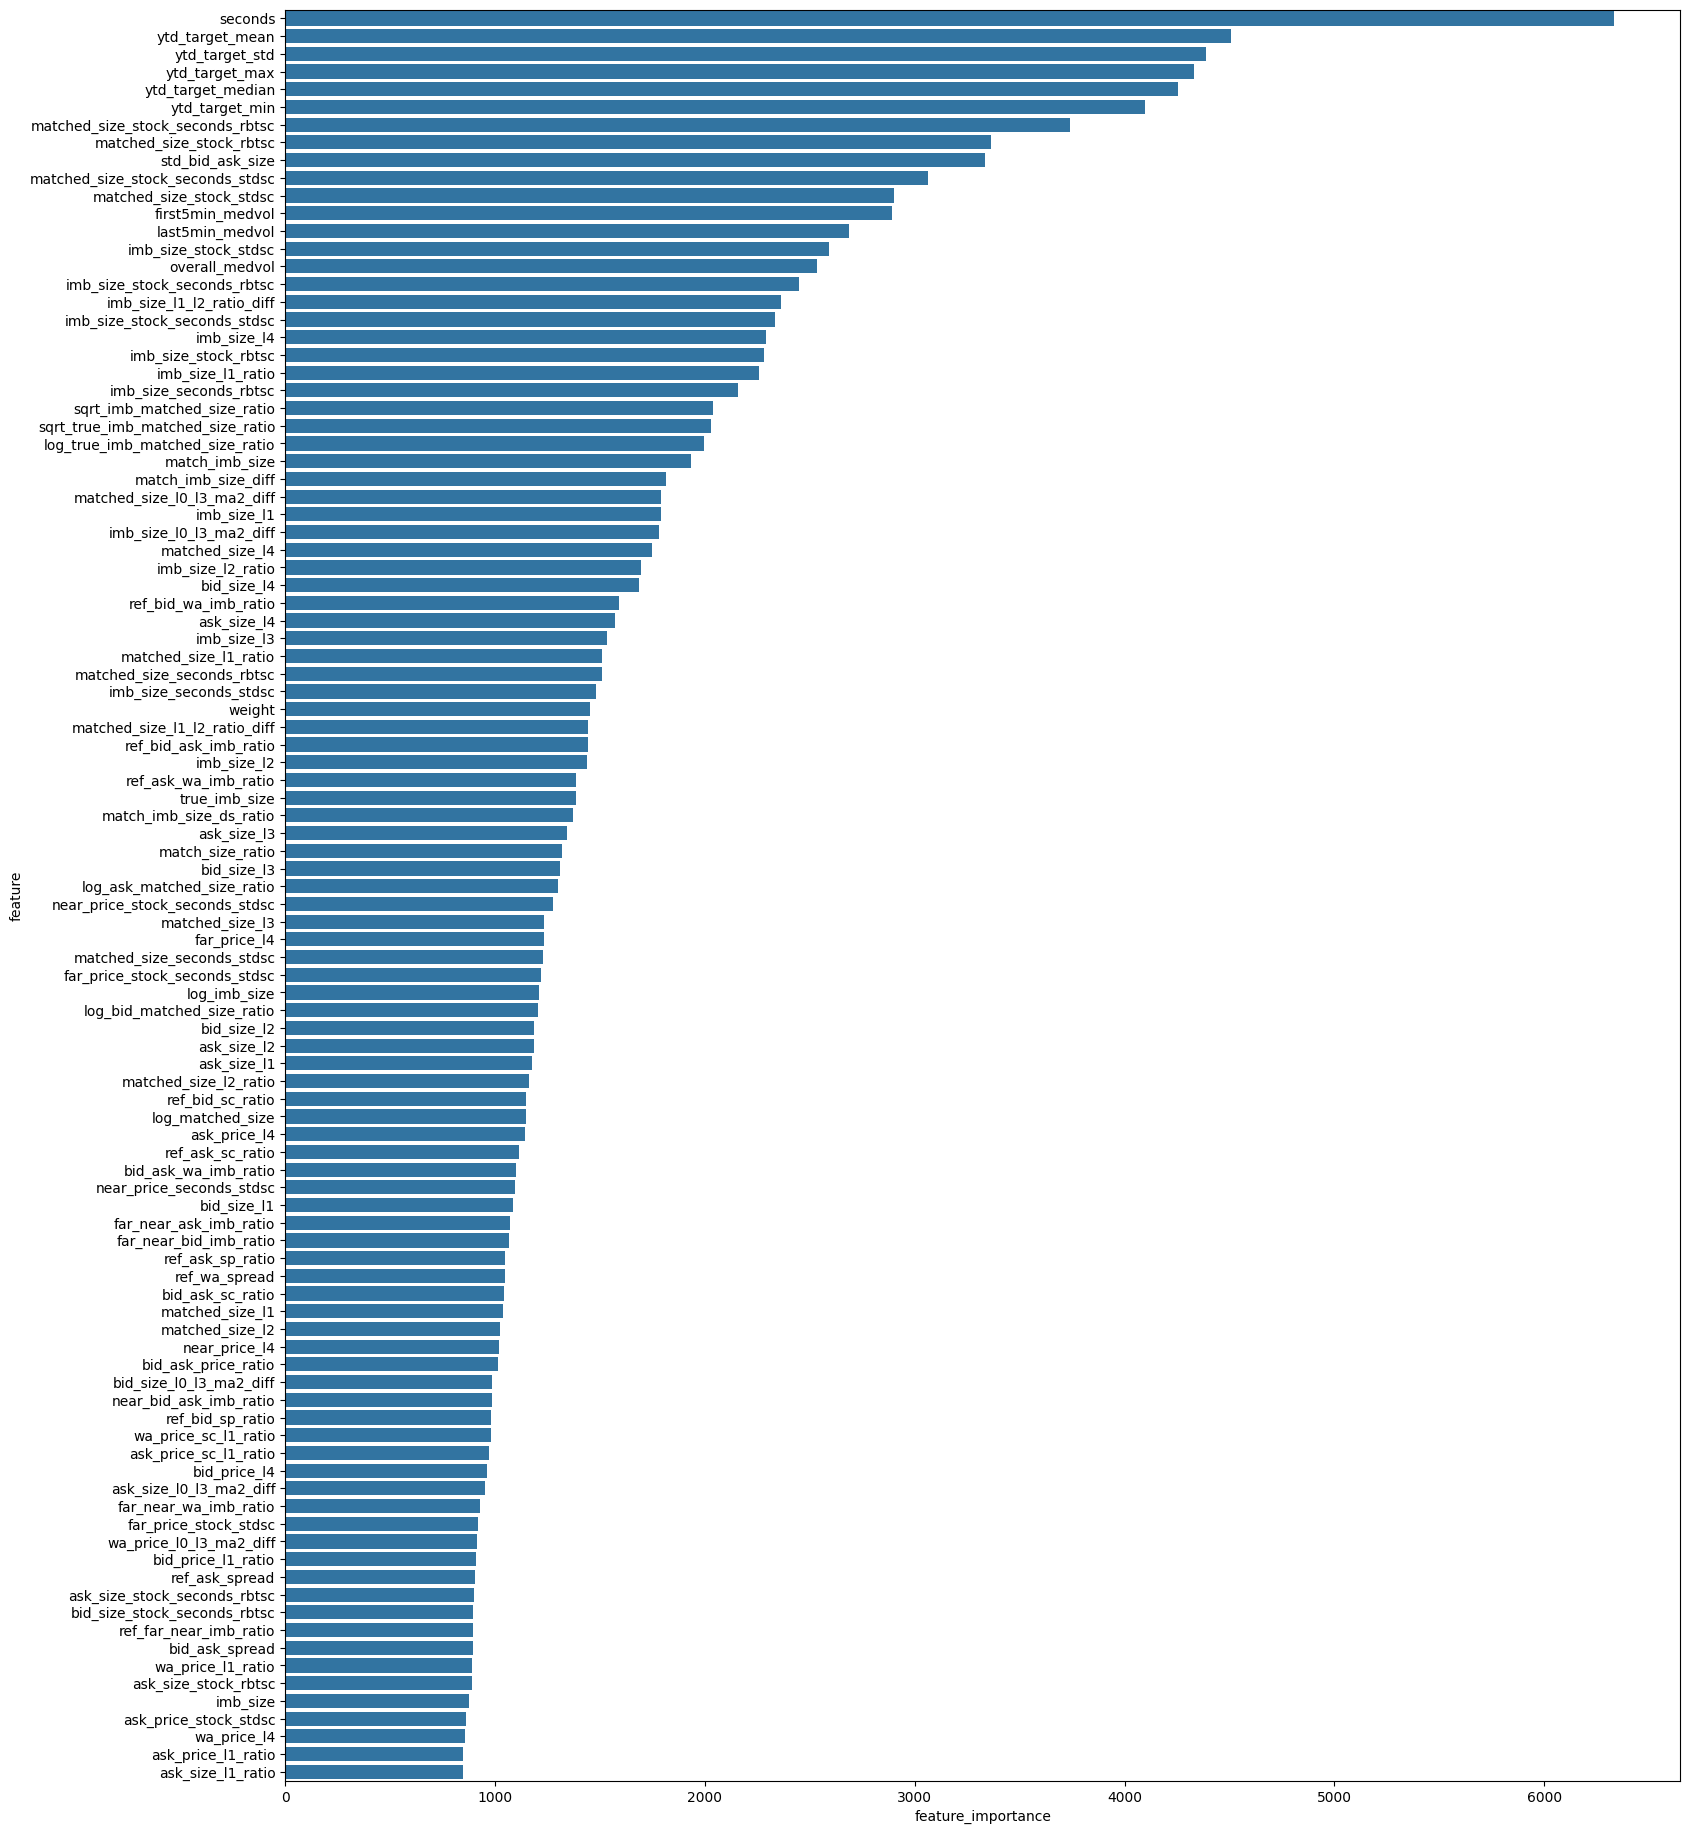

In [60]:
feature_imp_df = plot_feature_importance(
    features=model.feature_name(), importances=model.feature_importance(), return_df=True, limit=100, figsize=(18, 23)
)

In [206]:
%%time
feature_summary_df, feature_corr_df, linkage_matrix = get_feature_summary(bin_model, train, clustering_threshold=0.5)

15:02:19 Calculating Feature Correlation...
15:19:59 Forming Feature Clusters...
CPU times: user 8min 50s, sys: 5min 39s, total: 14min 29s
Wall time: 17min 40s


In [208]:
feature_summary_df

,feature,feature_importance,feature_importance_rank,clusters
0,seconds,7221,1,65
1,normalized_stock_date_target_max2_ma3_ma2_ratio,5819,2,67
2,normalized_stock_date_target_max_ma3_ma2_ratio,5725,3,74
3,normalized_stock_date_target_min_ma3_ma2_ratio,5699,4,68
4,normalized_stock_date_target_min2_ma3_ma2_ratio,5677,5,69
...,...,...,...,...
277,far_wa_sc_ratio,186,261,123
278,far_price_sc_l1_l2_ratio_diff,170,262,97
279,bid_ask_size_ratio,137,263,78
280,ref_far_sc_ratio,121,264,2


In [209]:
feature_summary_df.groupby("clusters")["feature"].count().sort_values(ascending=False)

clusters
133    9
123    9
4      7
121    6
132    6
      ..
60     1
25     1
35     1
102    1
67     1
Name: feature, Length: 133, dtype: int64

In [236]:
one_cluster_df = feature_summary_df.loc[feature_summary_df["clusters"] == 121]
one_cluster_df

,feature,feature_importance,feature_importance_rank,clusters
106,far_bid_ask_imb_ratio,1128,106,121
120,ref_far_bid_imb_ratio,990,119,121
123,ref_far_ask_imb_ratio,979,122,121
171,far_ask_wa_imb_ratio,776,164,121
174,far_bid_wa_imb_ratio,765,167,121
181,ref_far_wa_imb_ratio,741,172,121


In [237]:
features_to_drop = one_cluster_df["feature"].tolist()[1:]

In [245]:
features_to_drop

['ref_far_bid_imb_ratio',
 'ref_far_ask_imb_ratio',
 'far_ask_wa_imb_ratio',
 'far_bid_wa_imb_ratio',
 'ref_far_wa_imb_ratio']

In [60]:
feature_exp = pd.read_csv(r"../feature_experiment.csv")

In [62]:
i = 0

In [70]:
imp_list = []

In [71]:
for i in tqdm(range(50)):
    model = lgb.Booster(model_file=f"../models/lgbm/model{i}.txt")
    dict_ = dict(zip(model.feature_name(), model.feature_importance()))
    imp_list.append(dict_)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 25.76it/s]


In [73]:
feature_exp_imp = pd.DataFrame(imp_list)

In [80]:
feature_exp_imp["model_no"] = feature_exp["model_no"].astype(int)
feature_exp_imp["train_score"] = feature_exp["train_score"]
feature_exp_imp["va_score"] = feature_exp["va_score"]

In [79]:
feature_exp_imp = feature_exp_imp.reindex(columns=feature_exp.columns)

In [82]:
feature_exp_imp.to_csv(r"../feature_experiment_with_feature_importance.csv", index=False)

In [50]:
tlist, vlist = [], []
for col in feature_exp.columns[1:-2]:
    tlist.append(feature_exp.groupby(col)["train_score"].mean().diff().values[-1])
    vlist.append(feature_exp.groupby(col)["va_score"].mean().diff().values[-1])

In [51]:
result = pd.DataFrame(dict(feature=feature_exp.columns[1:-2], train_gain=tlist, val_gain=vlist))

In [52]:
result["train_gain_rank"] = result["train_gain"].rank(method="dense")
result["val_gain_rank"] = result["val_gain"].rank(method="dense")

In [53]:
potential_good_features = result.sort_values(by="val_gain_rank").iloc[:100].feature.tolist()

In [247]:
PRICE_MULTIPLIER = 10 # Factor to multiple the price col after taking the distance to 1
PRICE_POWER_FACTOR = 1/2 # Factor to transform the price col to bimodal distribution, the lower the further apart of the modes

In [248]:
%%time
va_score_list = []
model_list = []
va_pred_list = []
va_list = []
for i in [3]:
    cprint(f"{get_time_now()} Preparing Dataset...", color="green")
    
    tr = train.loc[train["date_id"].between(0, LAST_TRAIN_DATE)]
    # tr = train.loc[train["date_id"].between(0, 480)]
    cprint(f"Train shape {tr.shape}", color="yellow")
    train_data = lgb.Dataset(
        tr.drop(columns=target_column_list + cols_to_remove + features_to_drop, errors="ignore"), #.drop(columns=features_to_drop),
        tr["target"].values
    )
    del tr
    gc.collect()
    
    va = train.loc[train["date_id"].between(LAST_TRAIN_DATE + 1, 480)]
    valid_data = lgb.Dataset(
        va.drop(columns=target_column_list + cols_to_remove + features_to_drop, errors="ignore"), #.drop(columns=features_to_drop),
        va["target"].values,
        reference=train_data
    )
    
    cprint(f"{get_time_now()} Training...", color="green")
    model = lgb.train(
        params=final_lgbm_params,
        train_set=train_data, 
        valid_sets=[valid_data, train_data], 
        # feval=lgb_amex_metric, 
        # early_stopping_rounds=200,
        # categorical_feature=["stock_id"],
        callbacks=[
            log_evaluation(100),
        ]
    )
    del train_data, valid_data
    gc.collect()
    
#     model_list.append(model)
    va_pred = lgbm_inference_by_batch(model, va)
#     va_pred_list.append(va_pred)

    va_score = (va_pred - va["target"]).abs().mean()
    cprint(f"{get_time_now()} {va_score:.5f}", color="blue")
#     va_score_list.append(va_score)

17:26:05 Preparing Dataset...
Train shape (4577980, 288)
17:26:21 Training...
[100]	training's l1: 6.32011	valid_0's l1: 5.70649
[200]	training's l1: 6.27321	valid_0's l1: 5.69449
[300]	training's l1: 6.23598	valid_0's l1: 5.69143
[400]	training's l1: 6.20294	valid_0's l1: 5.69018
[500]	training's l1: 6.17411	valid_0's l1: 5.68992
[600]	training's l1: 6.14798	valid_0's l1: 5.69008


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:23<00:00,  3.48it/s]

17:36:30 5.69009
CPU times: user 1h 18min 14s, sys: 5min 4s, total: 1h 23min 18s
Wall time: 10min 25s


In [106]:
# lgbm_model2 = lgb.Booster(model_file='../models/lgbm/lgbm_model2.txt')
# lgbm_model3 = lgb.Booster(model_file='../models/lgbm/lgbm_model3.txt')

In [87]:
va["lgbm_pred2"] = lgbm_inference_by_batch(lgbm_model2, va)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:32<00:00,  2.48it/s]


In [93]:
va["lgbm_pred3"] = lgbm_inference_by_batch(lgbm_model3, va)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:47<00:00,  1.71it/s]


In [85]:
# model.save_model('../models/lgbm/lgbm_model3.txt')

In [49]:
va["lgbm_pred"] = va_pred

In [52]:
va.shape[0], keras_va.shape[0]

(660000, 551954)

In [50]:
keras_va = pd.read_parquet("../keras_val.parquet")

In [88]:
va["lgbm_pred2"]

4577980   -0.415797
4577981    2.407354
4577982   -1.593276
4577983    0.793018
4577984    3.466511
             ...   
5237975   -2.477129
5237976   -1.954007
5237977    0.032771
5237978    1.310975
5237979   -3.378635
Name: lgbm_pred2, Length: 660000, dtype: float64

In [94]:
(va["lgbm_pred3"] - va["target"]).abs().mean()

5.529154709318304

In [95]:
(va["lgbm_pred2"] - va["target"]).abs().mean()

5.5705429153648245

In [97]:
# (va["keras_pred"] - va["target"]).abs().mean()

In [79]:
# va["ensemble_pred"] = np.where(
#     va["keras_pred"].isnull(), 
#     va["lgbm_pred"],
#     (0.2 * va["keras_pred"] + 0.8 * va["lgbm_pred"])
# )

In [103]:
va["ensemble_pred"] = (0.1 * va["lgbm_pred2"] + 0.9 * va["lgbm_pred3"])

In [104]:
(va["ensemble_pred"] - va["target"]).abs().mean()

5.532514844776527

In [58]:
va = va.merge(keras_va[["stock_id", "date_id", "seconds", "keras_pred"]], on=["stock_id", "date_id", "seconds"], how="left")

In [ ]:
(keras_va["lgbm_pred"] - keras_va["target"]).abs().mean()

In [ ]:
5.69353

In [72]:
# for k in np.arange(20, 100, 5):
#     cprint(f"k: {k}", color="green", end="\t")
#     cprint(
#         f"Val Score: {(pd.Series(va_pred).fillna(0).clip(-k, k) - va['target'].values).abs().mean():.5f}", 
#         color="blue"
#     )

In [79]:
(va_pred - va["target"]).abs().mean()

5.693534621170634

In [ ]:
# %%time
# X_tr = feat_eng(tr).drop(columns=target_column_list + cols_to_remove)
# X_va = feat_eng(va).drop(columns=target_column_list + cols_to_remove)
# y_tr = tr[FINAL_TARGET_COLUMN].values
# y_va = va[FINAL_TARGET_COLUMN].values

In [ ]:
# %%time
# model = lgb.LGBMRegressor(
#     learning_rate=0.018052307589575444, 
#     max_depth=9, 
#     n_estimators=700,
#     num_leaves=442, 
#     objective='mae', 
#     random_state=42,
#     reg_alpha=0.02216069565875271, 
#     reg_lambda=0.01223572246957101
# )
# model.fit(X_tr, y_tr)

In [ ]:
# %%time
# y_tr_pred = model.predict(X_tr)
# tr_pred_df = pd.DataFrame(dict(gt=tr["target"], pred=y_tr_pred, bid_size=tr["bid_size"], ask_size=tr["ask_size"]))
# tr_pred_df.dropna(subset=["gt"], inplace=True)

In [ ]:
# y_va_pred = model.predict(X_va)
# va_pred_df = pd.DataFrame(dict(gt=va["target"], pred=y_va_pred, bid_size=va["bid_size"], ask_size=va["ask_size"]))
# va_pred_df.dropna(subset=["gt"], inplace=True)
# print((zero_sum(va_pred_df["pred"], va_pred_df["bid_size"] + va_pred_df["ask_size"]) - va_pred_df["gt"]).abs().mean())

In [ ]:
# y_va_pred = model.predict(X_va)
# va_pred_df = pd.DataFrame(dict(gt=va["target"], pred=y_va_pred, bid_size=va["bid_size"], ask_size=va["ask_size"]))
# va_pred_df.dropna(subset=["gt"], inplace=True)
# print((zero_sum(va_pred_df["pred"], va_pred_df["bid_size"] + va_pred_df["ask_size"]) - va_pred_df["gt"]).abs().mean())

In [ ]:
# sns.scatterplot(x=tr["target"], y=y_tr_pred)
# plt.show()

In [ ]:
# (zero_sum(tr_pred_df["pred"], tr_pred_df["bid_size"] + tr_pred_df["ask_size"]) - tr_pred_df["gt"]).abs().mean()

In [ ]:
# (zero_sum(va_pred_df["pred"], va_pred_df["bid_size"] + va_pred_df["ask_size"]) - va_pred_df["gt"]).abs().mean()

In [ ]:
# column = "log_imbalance_temp"
# target_column = "hollow_target"
# sns.scatterplot(x=va[column], y=va[target_column])
# plt.show()
# va[[column, target_column]].corr()

In [ ]:
# va["imbalance_temp"] = (va["imbalance_size"] - va["imbalance_mean"]) / va["imbalance_std"] * va["imbalance_buy_sell_flag"]

In [ ]:
# train["log_imbalance_size"] = np.log1p(train["imbalance_size"])
# va["log_imbalance_size"] = np.log1p(va["imbalance_size"])

In [ ]:
# imbalance_central_tendency = train.groupby("stock_id")["log_imbalance_size"].agg(["median", "mean", "std"]).add_prefix("log_imbalance_")
# va.drop(columns=imbalance_central_tendency.columns, errors="ignore", inplace=True)
# va = va.merge(imbalance_central_tendency, left_on=["stock_id"], right_index=True, how="left")

In [ ]:
# va["log_imbalance_temp"] = va["log_imbalance_size"] / va["log_imbalance_std"]

In [ ]:
# plot_feature_importance(model.feature_name_, model.feature_importances_)

# Prepare Submission

In [47]:
import optiver2023

In [48]:
SUBMIT = False

In [49]:
if SUBMIT:
    env = optiver2023.make_env()
    iter_test = env.iter_test()
else:
    iter_test = joblib.load("/kaggle/input/optiver-test-data/iter_test_copy.pkl")

In [50]:
# Inference on whole dataset, by batch
def lgbm_inference_by_batch(model, data, batch_size=8192):
    score_list = []
    for i in tqdm(range(int(data.shape[0] / batch_size) + 1)):
        try:
            score_list.extend(model.predict(
                data[model.feature_name()].iloc[int(i * batch_size): int((i+1) * batch_size)], 
            ))
        except:
            print("Too Many Batch")
    return score_list

In [51]:
lgbm_model = lgb.Booster(model_file='/kaggle/input/optiver-lgbm-models/lgbm_model2.txt')

In [54]:
test

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,row_id,order
0,0,478,0,3753451.43,-1,0.999875,11548975.43,NaN,NaN,0.999875,22940.00,1.000050,9177.60,1.0,478_0_0,0
1,1,478,0,985977.11,-1,1.000245,3850033.97,NaN,NaN,0.999940,1967.90,1.000601,19692.00,1.0,478_0_1,1
2,2,478,0,599128.74,1,1.000584,4359198.25,NaN,NaN,0.999918,4488.22,1.000636,34955.12,1.0,478_0_2,2
3,3,478,0,2872317.54,-1,0.999802,27129551.64,NaN,NaN,0.999705,16082.04,1.000189,10314.00,1.0,478_0_3,3
4,4,478,0,740059.14,-1,0.999886,8880890.78,NaN,NaN,0.999720,19012.35,1.000107,7245.60,1.0,478_0_4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,478,0,11075474.70,1,0.999672,11165016.52,NaN,NaN,0.999792,24960.00,1.000153,18310.60,1.0,478_0_195,195
196,196,478,0,1303523.55,1,0.999953,2280988.82,NaN,NaN,0.999953,4533.30,1.000206,19715.00,1.0,478_0_196,196
197,197,478,0,3920578.20,-1,1.000605,2969820.70,NaN,NaN,0.999650,5760.15,1.000318,5240.00,1.0,478_0_197,197
198,198,478,0,5074285.84,-1,1.000136,34865444.24,NaN,NaN,0.999894,74171.94,1.000136,95381.00,1.0,478_0_198,198


In [59]:
revealed_targets.groupby(["stock_id", "revealed_date_id"])["revealed_target"].describe()

,,count,mean,std,min,25%,50%,75%,max
stock_id,revealed_date_id,,,,,,,,
0,477,55.0,-1.736532,3.995226,-12.480021,-4.009902,-1.620054,1.245141,6.610155
1,477,55.0,-2.834667,6.917208,-20.099878,-5.914867,-0.249743,1.254678,7.640123
2,477,55.0,0.025966,9.563973,-14.389753,-5.804896,-1.839995,4.374981,27.610064
3,477,55.0,-0.940529,4.132701,-9.959936,-3.530085,-0.370145,0.964999,8.620024
4,477,55.0,0.487458,4.455853,-6.809831,-2.194941,-0.140071,2.444983,13.780594
...,...,...,...,...,...,...,...,...,...
195,477,55.0,1.95151,5.62217,-12.050271,-1.710057,2.510548,5.620122,15.920401
196,477,55.0,-2.73982,4.895452,-14.110208,-6.840229,-1.490116,0.734925,5.270243
197,477,55.0,-2.646381,6.36294,-16.149879,-7.130206,-1.320243,1.564622,11.310577


In [52]:
%%time
N = 3
temp_list = []
test_list = []
targets_list = []
sample_pred_list = []
for (test, revealed_targets, sample_prediction) in iter_test:
    test["order"] = range(test.shape[0])
    
    # Reset list if next day (seconds == 0) is seen
    second = test["seconds_in_bucket"].values[0]
    if second == 0:
        temp_list = []
    elif len(temp_list) == N:
        # If the list equals max_elem dataframes, remove the first dataframe then only append
        temp_list.pop(0)
        
    temp_list.append(test)
    
    # Concatenate the dataframes so that we can calculate lag features
    a = pd.concat(temp_list, ignore_index=True)
    
    # Clean & Preprocess, then apply feature engineering
    a = clean_df(a)
    a = clip_df(a, price_clippers=price_clippers, volume_clippers=volume_clippers)
    a, _ = feature_engineering(a, around_one_price_cols=around_one_price_cols, verbose=False)
    
    # Retrieve only the last 10-seconds row, since they are the 主角 for this batch
    a = a.loc[a["seconds"] == second].sort_values(by="order").drop(columns="order").reset_index(drop=True)

    # Prediction using our model(s)
    sample_prediction['target'] = lgbm_inference_by_batch(lgbm_model, data=a)
    sample_prediction['target'] = sample_prediction['target'].fillna(0).clip(-50, 50)
    
#     # Adjust our prediction using this function, actually I don't know what is its function
#     sample_prediction['target'] = zero_sum(
#         sample_prediction['target'], 
#         a['bid_size'] + a['ask_size']
#     ).values
    sample_pred_list.append(sample_prediction)
    
    if SUBMIT:
        # Need to call this env.predict to update / submit our prediction
        env.predict(sample_prediction)
        
    break

100%|██████████| 1/1 [00:00<00:00, 19.31it/s]

CPU times: user 363 ms, sys: 2.57 ms, total: 365 ms
Wall time: 324 ms


In [ ]:
if len(sample_pred_list) == 165:
    raw_train = pd.read_csv(f'{DATA_DIR}/optiver-trading-at-the-close/train.csv')
    result = pd.concat(sample_pred_list)
    result = result.merge(raw_train[["row_id", "target", "bid_size"]], on="row_id", how="left")
    print((result["target_x"] - result["target_y"]).abs().mean())

## Get Feature Summary & Plot Feature Cluster

In [38]:
# def plot_clustering_dendogram(linkage_matrix, distance_df):
#     fig, ax = plt.subplots(figsize=(19, 25))
#     dendrogram = sch.dendrogram(linkage_matrix, labels=distance_df.index, orientation='right')
#     plt.xlabel('Correlation Distance')
#     plt.title('Hierarchical Clustering Dendrogram')
#     plt.show()

In [39]:
# %%time
# feature_summary, feature_corr_df, feature_linkage_matrix = get_feature_summary(lgbm_model, train.sample(523798), clustering_threshold=1.5)
# plot_clustering_dendogram(feature_linkage_matrix, feature_corr_df)

# Previous Temporal Features Calculation

In [34]:
%%time
LOOK_BACK_DATE = 30
daily_global_target_stats = {}
for stats in ["mean", "median", "min", "max", "std"]:
    daily_global_target_stats[f"prev_date_global_target_{stats}"] = train.groupby("date_id")["target"].agg(stats).apply(
        lambda x: [x] # Convert the target mean into a list with just one item so that we can use cumsum to concatenate the daily target mean
    ).cumsum().apply(
        lambda x: x[::-1][:LOOK_BACK_DATE] # Reverse the list so that the most recent one is at the start, then truncated by only taking the first N most recent target
    ).shift(1) # Shift to avoid data leakage
    
daily_global_target_stats = pd.DataFrame(daily_global_target_stats).reset_index()
daily_global_target_stats

CPU times: user 284 ms, sys: 39.7 ms, total: 323 ms
Wall time: 322 ms


,date_id,prev_date_global_target_mean,prev_date_global_target_median,prev_date_global_target_min,prev_date_global_target_max,prev_date_global_target_std
0,0,None,None,None,None,None
1,1,[-0.5574731230735779],[-0.5298852920532227],[-60.200096130371094],[85.19053649902344],[8.168275833129883]
2,2,"[-0.2828964293003082, -0.5574731230735779]","[-0.2598762512207031, -0.5298852920532227]","[-130.82980346679688, -60.200096130371094]","[98.84953308105469, 85.19053649902344]","[9.041149139404297, 8.168275833129883]"
3,3,"[-0.1406160593032837, -0.2828964293003082, -0....","[-0.12993812561035156, -0.2598762512207031, -0...","[-66.77985382080078, -130.82980346679688, -60....","[96.4701156616211, 98.84953308105469, 85.19053...","[9.153743743896484, 9.041149139404297, 8.16827..."
4,4,"[-0.026630481705069542, -0.1406160593032837, -...","[-0.14007091522216797, -0.12993812561035156, -...","[-100.1900405883789, -66.77985382080078, -130....","[73.64988708496094, 96.4701156616211, 98.84953...","[8.285481452941895, 9.153743743896484, 9.04114..."
...,...,...,...,...,...,...
476,476,"[0.07772993296384811, -0.39757010340690613, -0...","[0.30994415283203125, -0.050067901611328125, -...","[-138.63026428222656, -133.70989990234375, -56...","[111.83976745605469, 268.87060546875, 51.61046...","[8.591558456420898, 13.051695823669434, 6.7846..."
477,477,"[-0.3104068636894226, 0.07772993296384811, -0....","[-0.209808349609375, 0.30994415283203125, -0.0...","[-64.12029266357422, -138.63026428222656, -133...","[61.78974914550781, 111.83976745605469, 268.87...","[7.446479320526123, 8.591558456420898, 13.0516..."
478,478,"[-0.1384873241186142, -0.3104068636894226, 0.0...","[-0.29981136322021484, -0.209808349609375, 0.3...","[-90.789794921875, -64.12029266357422, -138.63...","[71.05946350097656, 61.78974914550781, 111.839...","[7.664499759674072, 7.446479320526123, 8.59155..."
479,479,"[0.02312465012073517, -0.1384873241186142, -0....","[-0.029802322387695312, -0.29981136322021484, ...","[-89.76995849609375, -90.789794921875, -64.120...","[77.12960052490234, 71.05946350097656, 61.7897...","[7.532643795013428, 7.664499759674072, 7.44647..."


In [60]:
# daily_global_target_stats.to_parquet("../data/optiver-support-data/daily_global_target_stats.parquet")

In [42]:
%%time
LOOK_BACK_DATE = 30
train = train.sort_values(by=["stock_id", "date_id"]).reset_index(drop=True)
daily_stock_target_stats = {}
for stats in ["mean", "median", "min", "max", "std"]:
    daily_stock_target_stats[f"prev_date_stock_target_{stats}"] = train.groupby(["stock_id", "date_id"])["target"].agg(stats).apply(
        lambda x: [x] # Convert the target mean into a list with just one item so that we can use cumsum to concatenate the daily target mean
    ).cumsum().progress_apply(
        lambda x: x[::-1][:LOOK_BACK_DATE] # Reverse the list so that the most recent one is at the start, then truncated by only taking the first N most recent target
    ).shift(1) # Shift to avoid data leakage
    
daily_stock_target_stats = pd.DataFrame(daily_stock_target_stats).reset_index()
daily_stock_target_stats

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 95236/95236 [01:53<00:00, 839.66it/s]


CPU times: user 3min 24s, sys: 3min 32s, total: 6min 56s
Wall time: 11min 43s


,stock_id,date_id,prev_date_stock_target_mean,prev_date_stock_target_median,prev_date_stock_target_min,prev_date_stock_target_max,prev_date_stock_target_std
0,0,0,None,None,None,None,None
1,0,1,[-0.7345351576805115],[0.020265579223632812],[-10.679960250854492],[9.759664535522461],[4.185722827911377]
2,0,2,"[0.3289417624473572, -0.7345351576805115]","[1.0097026824951172, 0.020265579223632812]","[-14.08994197845459, -10.679960250854492]","[6.7996978759765625, 9.759664535522461]","[4.007033824920654, 4.185722827911377]"
3,0,3,"[-0.3267093300819397, 0.3289417624473572, -0.7...","[0.040531158447265625, 1.0097026824951172, 0.0...","[-15.569925308227539, -14.08994197845459, -10....","[8.629560470581055, 6.7996978759765625, 9.7596...","[5.143941879272461, 4.007033824920654, 4.18572..."
4,0,4,"[-3.2250990867614746, -0.3267093300819397, 0.3...","[-3.8701295852661133, 0.040531158447265625, 1....","[-17.899871826171875, -15.569925308227539, -14...","[8.759498596191406, 8.629560470581055, 6.79969...","[5.174627780914307, 5.143941879272461, 4.00703..."
...,...,...,...,...,...,...,...
95231,199,476,"[-0.3231005370616913, 0.9247280955314636, -1.9...","[0.30040740966796875, 1.519918441772461, -2.58...","[-12.249946594238281, -19.02997589111328, -12....","[11.14964485168457, 14.35995101928711, 6.09040...","[5.55213737487793, 6.242770195007324, 4.272174..."
95232,199,477,"[0.9665055871009827, -0.3231005370616913, 0.92...","[0.7402896881103516, 0.30040740966796875, 1.51...","[-10.579824447631836, -12.249946594238281, -19...","[12.860298156738281, 11.14964485168457, 14.359...","[5.772026538848877, 5.55213737487793, 6.242770..."
95233,199,478,"[-4.2260236740112305, 0.9665055871009827, -0.3...","[-4.870295524597168, 0.7402896881103516, 0.300...","[-15.050172805786133, -10.579824447631836, -12...","[3.7097930908203125, 12.860298156738281, 11.14...","[4.536808013916016, 5.772026538848877, 5.55213..."
95234,199,479,"[1.3231254816055298, -4.2260236740112305, 0.96...","[1.920461654663086, -4.870295524597168, 0.7402...","[-11.900067329406738, -15.050172805786133, -10...","[13.500452041625977, 3.7097930908203125, 12.86...","[5.631494998931885, 4.536808013916016, 5.77202..."


In [45]:
# daily_stock_target_stats.to_parquet("../data/optiver-support-data/daily_stock_target_stats.parquet")

In [96]:
daily_target_stats = daily_stock_target_stats.merge(daily_global_target_stats, on="date_id", how="left")
daily_target_stats = daily_target_stats.dropna()

In [104]:
for col in daily_target_stats.columns[2:]:
    daily_target_stats[col] = daily_target_stats[col].apply(np.array)

In [109]:
daily_target_stats["prev_date_stock_target_mean"].iloc[3] - daily_target_stats["prev_date_global_target_mean"].iloc[3]

array([-3.19846861, -0.18609327,  0.61183819, -0.17706203])

In [ ]:
def pr(row):
    try:
        row.prev_date_stock_target_mean - row.prev_date_global_target_mean

In [116]:
daily_target_stats.loc[daily_target_stats["prev_date_stock_target_mean"].str.len() != daily_target_stats["prev_date_global_target_mean"].str.len()]

,stock_id,date_id,prev_date_stock_target_mean,prev_date_stock_target_median,prev_date_stock_target_min,prev_date_stock_target_max,prev_date_stock_target_std,prev_date_global_target_mean,prev_date_global_target_median,prev_date_global_target_min,prev_date_global_target_max,prev_date_global_target_std
482,1,1,"[1.1445717811584473, 0.5915165543556213, -1.39...","[-1.5497207641601562, 0.6496906280517578, -0.1...","[-10.449886322021484, -10.420083999633789, -11...","[28.949975967407227, 8.510351181030273, 6.4694...","[8.197073936462402, 3.9718258380889893, 4.3429...",[-0.5574731230735779],[-0.5298852920532227],[-60.200096130371094],[85.19053649902344],[8.168275833129883]
483,1,2,"[1.6627745628356934, 1.1445717811584473, 0.591...","[1.4102458953857422, -1.5497207641601562, 0.64...","[-11.969804763793945, -10.449886322021484, -10...","[16.280412673950195, 28.949975967407227, 8.510...","[6.597947597503662, 8.197073936462402, 3.97182...","[-0.2828964293003082, -0.5574731230735779]","[-0.2598762512207031, -0.5298852920532227]","[-130.82980346679688, -60.200096130371094]","[98.84953308105469, 85.19053649902344]","[9.041149139404297, 8.168275833129883]"
484,1,3,"[0.07706336677074432, 1.6627745628356934, 1.14...","[1.0395050048828125, 1.4102458953857422, -1.54...","[-24.639965057373047, -11.969804763793945, -10...","[34.1796875, 16.280412673950195, 28.9499759674...","[12.275678634643555, 6.597947597503662, 8.1970...","[-0.1406160593032837, -0.2828964293003082, -0....","[-0.12993812561035156, -0.2598762512207031, -0...","[-66.77985382080078, -130.82980346679688, -60....","[96.4701156616211, 98.84953308105469, 85.19053...","[9.153743743896484, 9.041149139404297, 8.16827..."
485,1,4,"[1.6297861337661743, 0.07706336677074432, 1.66...","[1.7201900482177734, 1.0395050048828125, 1.410...","[-16.07000732421875, -24.639965057373047, -11....","[17.080307006835938, 34.1796875, 16.2804126739...","[8.477258682250977, 12.275678634643555, 6.5979...","[-0.026630481705069542, -0.1406160593032837, -...","[-0.14007091522216797, -0.12993812561035156, -...","[-100.1900405883789, -66.77985382080078, -130....","[73.64988708496094, 96.4701156616211, 98.84953...","[8.285481452941895, 9.153743743896484, 9.04114..."
486,1,5,"[-0.2847476303577423, 1.6297861337661743, 0.07...","[-2.2101402282714844, 1.7201900482177734, 1.03...","[-14.380216598510742, -16.07000732421875, -24....","[19.919872283935547, 17.080307006835938, 34.17...","[9.826698303222656, 8.477258682250977, 12.2756...","[-0.11555680632591248, -0.026630481705069542, ...","[0.059604644775390625, -0.14007091522216797, -...","[-81.4300765991211, -100.1900405883789, -66.77...","[64.69010925292969, 73.64988708496094, 96.4701...","[8.244714736938477, 8.285481452941895, 9.15374..."
...,...,...,...,...,...,...,...,...,...,...,...,...
94387,198,25,"[-0.48817288875579834, 0.39641425013542175, 1....","[-1.0901689529418945, 1.1301040649414062, 1.46...","[-6.369948387145996, -11.069774627685547, -7.4...","[6.510019302368164, 4.71949577331543, 7.890462...","[2.9460933208465576, 3.5450358390808105, 3.744...","[-0.43549665808677673, -0.12510010600090027, 0...","[-0.5799531936645508, 0.050067901611328125, 0....","[-69.19026184082031, -43.9101448059082, -53.33...","[44.46983337402344, 64.17990112304688, 53.0803...","[6.154864311218262, 7.035421848297119, 6.70116..."
94388,198,26,"[-0.2252296805381775, -0.48817288875579834, 0....","[-1.0597705841064453, -1.0901689529418945, 1.1...","[-10.780096054077148, -6.369948387145996, -11....","[17.420053482055664, 6.510019302368164, 4.7194...","[6.7027130126953125, 2.9460933208465576, 3.545...","[-0.1317184865474701, -0.43549665808677673, -0...","[0.08940696716308594, -0.5799531936645508, 0.0...","[-82.03983306884766, -69.19026184082031, -43.9...","[40.88043975830078, 44.46983337402344, 64.1799...","[7.143494606018066, 6.154864311218262, 7.03542..."
94389,198,27,"[-1.9321658611297607, -0.2252296805381775, -0....","[-2.250075340270996, -1.0597705841064453, -1.0...","[-11.039972305297852

In [56]:
%%time
new_feature_list = []
for i in [3, 5, 7, 9]:
    for stats in ["mean", "median", "min", "max", "std"]:
        new_feature_name = f"target_{stats}_ma{i}"
        daily_target_stats[new_feature_name] = daily_target_stats[f"prev_date_stock_target_{stats}"].apply(lambda x: np.mean(x[:i]) if x is not None else np.nan)
        new_feature_list.append(new_feature_name)

CPU times: user 5.39 s, sys: 46.4 ms, total: 5.43 s
Wall time: 5.43 s


In [62]:
%%time
train = train.merge(
    daily_target_stats[["stock_id", "date_id"] + new_feature_list],
    on=["stock_id", "date_id"],
    how="left"
)

CPU times: user 898 ms, sys: 3.64 s, total: 4.53 s
Wall time: 7.6 s


In [63]:
# fig, ax = plt.subplots(figsize=(18, 7))
# ax.plot(range(480 - LOOK_BACK_DATE, 480), daily_global_target_stats["prev_date_target_mean"][480], label="target_mean")
# plt.xlabel("Date ID")
# plt.title("Previous Date Average Target")
# plt.show()

## Feature Experiment

In [ ]:
for i in tqdm(range(15, 50)):
    model = lgb.Booster(model_file=f'../models/lgbm/model{i}.txt')
    result = pd.concat([result, pd.DataFrame([{k: 1 for k in model.feature_name()}])], ignore_index=True)
    result.iloc[i] = result.iloc[i].fillna(0)
    va_pred = lgbm_inference_by_batch(model, va, verbose=0)
    train_pred = lgbm_inference_by_batch(model, tr, verbose=0)
    
    train_score = (tr["target"] - train_pred).abs().mean()
    va_score = (va["target"] - va_pred).abs().mean()
    
    result.loc[i, "train_score"] = train_score
    result.loc[i, "va_score"] = va_score
    result.loc[i, "model_no"] = i
# result.to_csv("../feature_experiment.csv", index=False)

## Get Rolling Columns

In [411]:
# %%time
# master_rolling_features = pd.read_parquet(f"{DATA_DIR}/optiver-train-data/rolling_targets.parquet")

In [412]:
# master_df = master_df.merge(
#     master_rolling_features, on=META_COLUMNS, how="left"
# )

In [ ]:
def get_rolling_columns(df, base_column, window_size=18, group_column=["stock_id", "date_id"], lag=0):
    df = df.sort_values(by=META_COLUMNS).reset_index(drop=True)
    column_name = f"{base_column}_l{lag}"
    if lag > 0:
        df[column_name] = df.groupby(group_column)[base_column].shift(lag)
    else:
        df[column_name] = df[base_column]
    
    temp_list = []
    for i, window in tqdm(enumerate(df.groupby(group_column).rolling(window=window_size))):
        array = window[column_name].to_numpy()
        if window_size > len(array):
            array = np.pad(array, (window_size - len(array), 0), constant_values=np.nan)
        temp_list.append(array)
    
    if lag > 0:
        df[f"{base_column}_w{window_size}_l{lag}"] = temp_list
    else:
        df[f"{base_column}_w{window_size}"] = temp_list
    df.drop(columns=column_name, errors="ignore", inplace=True)
    return df

In [417]:
# for base_col in base_columns:
#     cprint(f'Doing {base_col}', color="blue")
#     master_df = get_rolling_columns(master_df, base_column=base_col, window_size=18, group_column=["stock_id", "date_id"], lag=0)
    
#     if base_col.endswith("_size"):
#         master_df[f"log_{base_col}"] = my_log(master_df[base_col])
#         master_df = get_rolling_columns(master_df, base_column=f"log_{base_col}", window_size=18, group_column=["stock_id", "date_id"], lag=0)
    
#     if base_col.endswith("_price"):
#         master_df[f"c_{base_col}"] = (master_df[base_col] - 1)
#         master_df = get_rolling_columns(master_df, base_column=f"c_{base_col}", window_size=18, group_column=["stock_id", "date_id"], lag=0)

In [418]:
# for target_col in ["target", "is_positive_target", "is_mild_target"]:
#     cprint(f'Doing {target_col}', color="blue")
#     master_df = get_rolling_columns(master_df, base_column=target_col, window_size=18, group_column=["stock_id", "date_id"], lag=6)

In [419]:
# for col in get_cols(master_df, endswith="w18", excludes="c_"):
#     cprint(f"Fit regression line for {col}...", color="blue")
#     master_df[[f"{col}_gradient", f"{col}_intercept"]] = master_df[col].progress_apply(
#         lambda r: np.polyfit(range(len(r)), (r - np.mean(r)) / np.std(r), 1)
#     ).apply(pd.Series).values

In [420]:
# master_df[META_COLUMNS + get_cols(master_df, endswith=["_w18_l6", "_w18"])].to_parquet(f"{DATA_DIR}/optiver-train-data/rolling_targets.parquet")

In [ ]:
# master_df["target_l6_w12_mean"] = master_df["target_l6_w12"].progress_apply(np.mean)
# master_df["target_l6_w12_median"] = master_df["target_l6_w12"].progress_apply(np.median)
# master_df["target_l6_w12_std"] = master_df["target_l6_w12"].progress_apply(np.std)

# Group By Apa2

## Groupby Stock ID

In [386]:
stock_level_stats_ = pd.read_parquet(f"{DATA_DIR}/optiver-support-data/stock_level_stats_.parquet")
stock_level_stats = pd.read_parquet(f"{DATA_DIR}/optiver-support-data/stock_level_stats.parquet")

In [389]:
for col in get_cols(stock_level_stats, "size"):
    stock_level_stats_[col] = my_log(stock_level_stats_[col])
    stock_level_stats[col] = my_log(stock_level_stats[col])

In [390]:
# stock_level_stats_ = stock_level_stats_.reset_index()
# stock_level_stats = stock_level_stats.reset_index()

In [391]:
base_columns

['ask_price',
 'ask_size',
 'bid_price',
 'bid_size',
 'far_price',
 'imb_size',
 'matched_size',
 'near_price',
 'ref_price',
 'wa_price']

In [392]:
train = scale_base_columns(
    train, 
    _level_stats_df=stock_level_stats_, 
    level_col="stock", 
    join_col="stock_id", 
    base_columns=base_columns
)
val = scale_base_columns(
    val, 
    _level_stats_df=stock_level_stats, 
    level_col="stock", 
    join_col="stock_id", 
    base_columns=base_columns
)

## Groupby Seconds

In [31]:
seconds_level_stats_ = pd.read_parquet(f"{DATA_DIR}/optiver-support-data/seconds_level_stats_.parquet")
seconds_level_stats = pd.read_parquet(f"{DATA_DIR}/optiver-support-data/seconds_level_stats.parquet")

In [32]:
for col in get_cols(seconds_level_stats, "size"):
    seconds_level_stats_[col] = my_log(seconds_level_stats_[col])
    seconds_level_stats[col] = my_log(seconds_level_stats[col])

In [33]:
train = scale_base_columns(
    train, 
    _level_stats_df=seconds_level_stats_, 
    level_col="seconds", 
    join_col="seconds", 
    base_columns=base_columns
)
val = scale_base_columns(
    val, 
    _level_stats_df=seconds_level_stats, 
    level_col="seconds", 
    join_col="seconds", 
    base_columns=base_columns
)

## Groupby Date

In [34]:
date_level_stats_ = pd.read_parquet(f"{DATA_DIR}/optiver-support-data/date_level_stats_.parquet")
date_level_stats = pd.read_parquet(f"{DATA_DIR}/optiver-support-data/date_level_stats.parquet")

In [35]:
for col in get_cols(date_level_stats, "size"):
    date_level_stats_[col] = my_log(date_level_stats_[col])
    date_level_stats[col] = my_log(date_level_stats[col])

In [36]:
train = scale_base_columns(
    train, 
    _level_stats_df=date_level_stats_, 
    level_col="date", 
    join_col="date_id", 
    base_columns=base_columns
)
val = scale_base_columns(
    val, 
    _level_stats_df=date_level_stats, 
    level_col="date", 
    join_col="date_id", 
    base_columns=base_columns
)

## Groupby Stock Date

In [37]:
stock_date_level_stats_ = pd.read_parquet(f"{DATA_DIR}/optiver-support-data/stock_date_level_stats_.parquet")
stock_date_level_stats = pd.read_parquet(f"{DATA_DIR}/optiver-support-data/stock_date_level_stats.parquet")

In [38]:
for col in get_cols(stock_date_level_stats, "size"):
    stock_date_level_stats_[col] = my_log(stock_date_level_stats_[col])
    stock_date_level_stats[col] = my_log(stock_date_level_stats[col])

In [39]:
train = scale_base_columns(
    train, 
    _level_stats_df=stock_date_level_stats_, 
    level_col="stock_date", 
    join_col=["stock_id", "date_id"], 
    base_columns=base_columns
)
val = scale_base_columns(
    val, 
    _level_stats_df=stock_date_level_stats, 
    level_col="stock_date", 
    join_col=["stock_id", "date_id"], 
    base_columns=base_columns
)

## Groupby Stock Seconds

In [40]:
stock_seconds_level_stats_ = pd.read_parquet(f"{DATA_DIR}/optiver-support-data/stock_seconds_level_stats_.parquet")
stock_seconds_level_stats = pd.read_parquet(f"{DATA_DIR}/optiver-support-data/stock_seconds_level_stats.parquet")

In [41]:
for col in get_cols(stock_seconds_level_stats, "size"):
    stock_seconds_level_stats_[col] = my_log(stock_seconds_level_stats_[col])
    stock_seconds_level_stats[col] = my_log(stock_seconds_level_stats[col])

In [42]:
train = scale_base_columns(
    train, 
    _level_stats_df=stock_seconds_level_stats_, 
    level_col="stock_seconds", 
    join_col=["stock_id", "seconds"], 
    base_columns=base_columns
)
val = scale_base_columns(
    val, 
    _level_stats_df=stock_seconds_level_stats, 
    level_col="stock_seconds", 
    join_col=["stock_id", "seconds"], 
    base_columns=base_columns
)

In [43]:
psi_list = []
for feature in get_cols(val, contains=["price", "val"]):
    psi_ = calculate_psi(train[feature].clip(1e6, -1e6).dropna(), val[feature].clip(1e6, -1e6).dropna())
    if psi_ > 0.2:
        cprint(f"PSI for {feature}: {psi_:.4f}", color="red")
    elif psi_ > 0.1:
        cprint(f"PSI for {feature}: {psi_:.4f}", color="yellow")
    else:
        cprint(f"PSI for {feature}: {psi_:.4f}", color="blue")
    psi_list.append(psi_)

PSI for ref_price: 0.1476
PSI for far_price: 0.1782
PSI for near_price: 0.0903
PSI for bid_price: 0.1442
PSI for ask_price: 0.1513
PSI for wa_price: 0.1102
PSI for ask_price_stock_rbtsc: 0.1699
PSI for ask_price_stock_stdsc: 0.1738
PSI for bid_price_stock_rbtsc: 0.1659
PSI for bid_price_stock_stdsc: 0.1719
PSI for far_price_stock_rbtsc: 0.1446
PSI for far_price_stock_stdsc: 0.1118
PSI for near_price_stock_rbtsc: 0.1232
PSI for near_price_stock_stdsc: 0.0930
PSI for ref_price_stock_rbtsc: 0.1678
PSI for ref_price_stock_stdsc: 0.1770
PSI for wa_price_stock_rbtsc: 0.1764
PSI for wa_price_stock_stdsc: 0.1840
PSI for ask_price_seconds_rbtsc: 0.1572
PSI for ask_price_seconds_stdsc: 0.1598
PSI for bid_price_seconds_rbtsc: 0.1399
PSI for bid_price_seconds_stdsc: 0.1514
PSI for far_price_seconds_rbtsc: 0.1149
PSI for far_price_seconds_stdsc: 0.1127
PSI for near_price_seconds_rbtsc: 0.0771
PSI for near_price_seconds_stdsc: 0.0929
PSI for ref_price_seconds_rbtsc: 0.1496
PSI for ref_price_seconds_

In [44]:
train = pd.concat([train, val], ignore_index=True)

In [45]:
# (train.isnull().sum() / train.shape[0]).sort_values()[-30:]

In [46]:
# price_and_vol_columns = get_cols(train, contains=["_price", "_size"], excludes=["scaled"])
# base_col_stock_avg_ref = train.groupby("stock_id")[price_and_vol_columns].mean().add_suffix("_mean")
# base_col_stock_std_ref = train.groupby("stock_id")[price_and_vol_columns].std().add_suffix("_std")
# base_col_date_avg_ref = train.groupby("date_id")[price_and_vol_columns].mean().add_suffix("_mean")
# base_col_date_std_ref = train.groupby("date_id")[price_and_vol_columns].std().add_suffix("_std")

# def scale(df):
#     # Get the base price and base volume columns (base means it is raw or raw after transformed)
#     price_and_vol_columns = get_cols(df, contains=["_price", "_size"], excludes=["scaled"])
    
#     # Merge the per-stock base columns avg and std reference prepared before-hand
#     df = df.merge(base_col_stock_avg_ref, on=["stock_id"], how="left")
#     df = df.merge(base_col_stock_std_ref, on=["stock_id"], how="left")
    
#     # For each of the base column, standardized it using the stock ID mean and stock ID std
#     for col in tqdm(price_and_vol_columns):
#         df["sc_stock_" + col] = (df[col] - df[col + "_mean"]) / df[col + "_std"]
        
#     # Remove the redundant avg & std reference columns
#     df.drop(columns=list(base_col_stock_avg_ref) + list(base_col_stock_std_ref), errors="ignore", inplace=True)
    
#     # Merge the per-date base columns avg and std reference prepared before-hand
#     df = df.merge(base_col_date_avg_ref, on=["date_id"], how="left")
#     df = df.merge(base_col_date_std_ref, on=["date_id"], how="left")
    
#     # For each of the base column, standardized it using the date ID mean and date ID std
#     for col in tqdm(price_and_vol_columns):
#         df["sc_date_" + col] = (df[col] - df[col + "_mean"]) / df[col + "_std"]
        
#     # Remove the redundant avg & std reference columns
#     df.drop(columns=list(base_col_date_avg_ref) + list(base_col_date_std_ref), errors="ignore", inplace=True)
    
#     return df

In [47]:
# %%time
# train = scale(train)